# Semi-Supervised Learning : Self-training

In [93]:
% matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading
from sklearn.datasets import make_circles
from scipy.sparse import csgraph
from scipy.spatial import distance
import csv, time
import numpy as np

np.seterr(divide='ignore', invalid='ignore')
plt.rcParams.update({'figure.max_open_warning': 0})

## 1-Nearest Neighbor 구현

In [94]:
def nn_self(label_A, label_B, unlabeled):
    plt.figure(figsize=(8.5, 4))
    draw_self(label_A, label_B, unlabeled, 1)
    while unlabeled:
        # unlabeled된 점들과 labeled된 점들 사이의 거리를 구한 후 제일 가까운 데이터를 label
        dist_A = [{'from': A, 'to': item, 'dist': distance.euclidean(A, item)} for A in label_A for item in unlabeled]
        dist_B = [{'from': B, 'to': item, 'dist': distance.euclidean(B, item)} for B in label_B for item in unlabeled]
        min_A = min(dist_A, key=lambda x: x['dist'])
        min_B = min(dist_B, key=lambda x: x['dist'])
        if min_A['dist'] < min_B['dist']:
            label_A.append(min_A['to'])
            unlabeled.remove(min_A['to'])
        else:
            label_B.append(min_B['to'])
            unlabeled.remove(min_B['to'])

    draw_self(label_A, label_B, unlabeled, 2)
    plt.show()
    return label_A, label_B

In [149]:
def draw_self(label_A, label_B, unlabeled, opt):
    plt.subplot(1, 2, opt)
    plt.scatter([p[0] for p in label_A], [p[1] for p in label_A], color='navy',
                marker='s', lw=0, label="label A", s=10)
    plt.scatter([p[0] for p in label_B], [p[1] for p in label_B], color='c',
                marker='s', lw=0, label='label B', s=10)
    if unlabeled:
        plt.scatter([p[0] for p in unlabeled], [p[1] for p in unlabeled], color='darkorange',
                    marker='.', label='unlabeled')
    plt.legend(scatterpoints=1, shadow=False, loc='upper right')
    if unlabeled:
        plt.title("Before")
    else:
        plt.title("After")

def generate_data(n, std):
    np.random.seed(999)
    data_A = [(x, y) for x in np.random.normal(-50, std, n) for y in np.random.normal(-50, std, n)]
    data_B = [(x, y) for x in np.random.normal(50, std, n) for y in np.random.normal(50, std, n)]
    return data_A, data_B

## 20의 표준편차를 가지는 2개의 가우시안 분포를 NN알고리즘으로 분류

In [96]:
def test_self():
    data_A, data_B = generate_data(10, 20)
    label_A = [data_A[0]]
    label_B = [data_B[-1]]
    unlabeled = data_A[1:] + data_B[:-1]
    ti = time.clock()
    nn_self(label_A, label_B, unlabeled)
    te = time.clock()
    print('{}s'.format(te - ti))

<IPython.core.display.Javascript object>


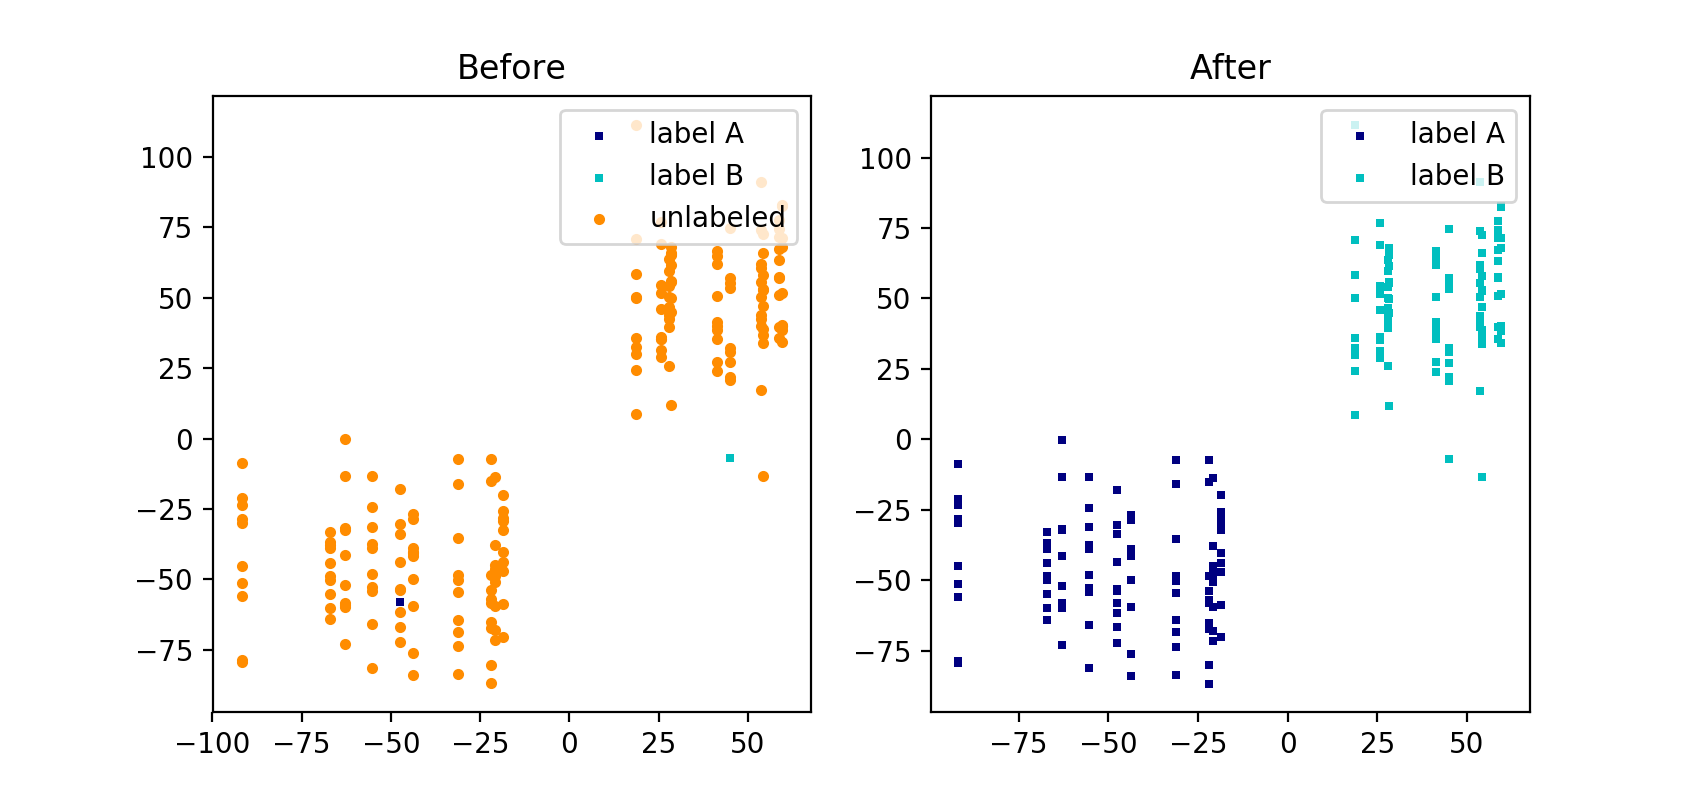

21.455601s


In [97]:
test_self()

## 노이즈를 더했을 때 결과 비교

In [98]:
def test_self_with_noise():
    data_A, data_B = generate_data(10, 20)
    label_A = [data_A[0]]
    label_B = [data_B[-1]]
    unlabeled = data_A[1:] + data_B[:-1]
    
    # noise added
    unlabeled.append((-5, -5))
    unlabeled.append((0, 0))
    unlabeled.append((5, 5))
    
    nn_self(label_A, label_B, unlabeled)

<IPython.core.display.Javascript object>


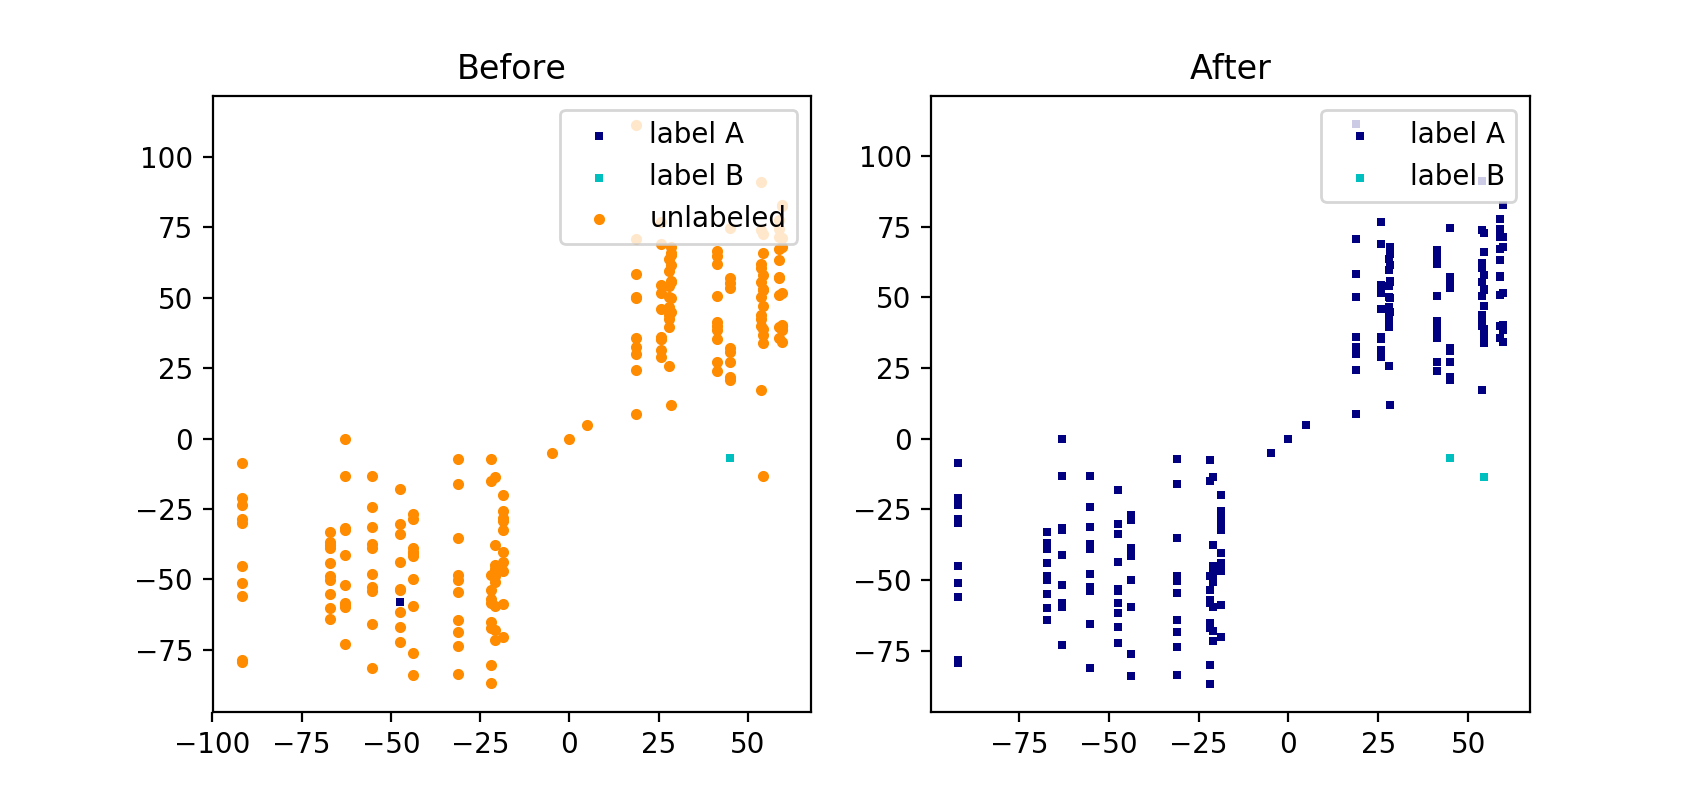

In [99]:
test_self_with_noise()

## 성능 문제로 sklearn.semi_supervised 라이브러리 사용

In [150]:
def knn(X, labels):
    # #############################################################################
    # Learn with LabelSpreading
    label_spread = LabelSpreading(kernel='knn', alpha=0.8, max_iter=1000)
    label_spread.fit(X, labels)

    # #############################################################################
    # Plot output labels
    output_labels = label_spread.transduction_

    return output_labels


def draw(X, labels, output_labels):
    label_0, label_1, unlabeled = 0, 1, -1

    plt.figure(figsize=(8.5, 4))

    plt.subplot(1, 2, 1)
    plt.scatter(X[labels == unlabeled, 0], X[labels == unlabeled, 1], color='darkorange',
                marker='.', label='unlabeled')
    plt.scatter(X[labels == label_0, 0], X[labels == label_0, 1], color='navy',
                marker='s', lw=0, label="0 labeled", s=10)
    plt.scatter(X[labels == label_1, 0], X[labels == label_1, 1], color='c',
                marker='s', lw=0, label='1 labeled', s=10)

    plt.legend(scatterpoints=1, shadow=False, loc='upper right')
    plt.title("Before")

    plt.subplot(1, 2, 2)
    output_label_array = np.asarray(output_labels)
    label_0_numbers = np.where(output_label_array == label_0)[0]
    label_1_numbers = np.where(output_label_array == label_1)[0]
    plt.scatter(X[label_0_numbers, 0], X[label_0_numbers, 1], color='navy',
                marker='s', lw=0, s=10, label="0 learned")
    plt.scatter(X[label_1_numbers, 0], X[label_1_numbers, 1], color='c',
                marker='s', lw=0, s=10, label="1 learned")
    plt.legend(scatterpoints=1, shadow=False, loc='upper right')
    plt.title("After")

## 2016년 Tutorial중 8조 조수현 학생이 사용한 데이터셋들로 실험
    - bullseye
    - Data1,2,3
    - impactOfNoise
    - jain
    - tricircle
    - twomoon
    - 각각 label된 데이터의 비율이 다르게(0.02, 0.05, 0.1, 0.2, 0.5) 실험

In [152]:
def parse(file):
    X, labels = list(), list()
    with open(file, 'r') as f:
        dr = csv.DictReader(f)
        for row in dr:
            X.append((float(row['V1']), float(row['V2'])))
            if row['V3'].strip() == '':
                labels.append(-1)
            else:
                labels.append(int(row['V3']) - 1)

    return np.array(X), np.array(labels)


def run(dataset, label_rate):
    X, labels = parse('../../data/{}/tr_{}.csv'.format(dataset, label_rate))
    output_labels = knn(X, labels)
    draw(X, labels, output_labels)
    plt.show()



## - bullseye

<IPython.core.display.Javascript object>


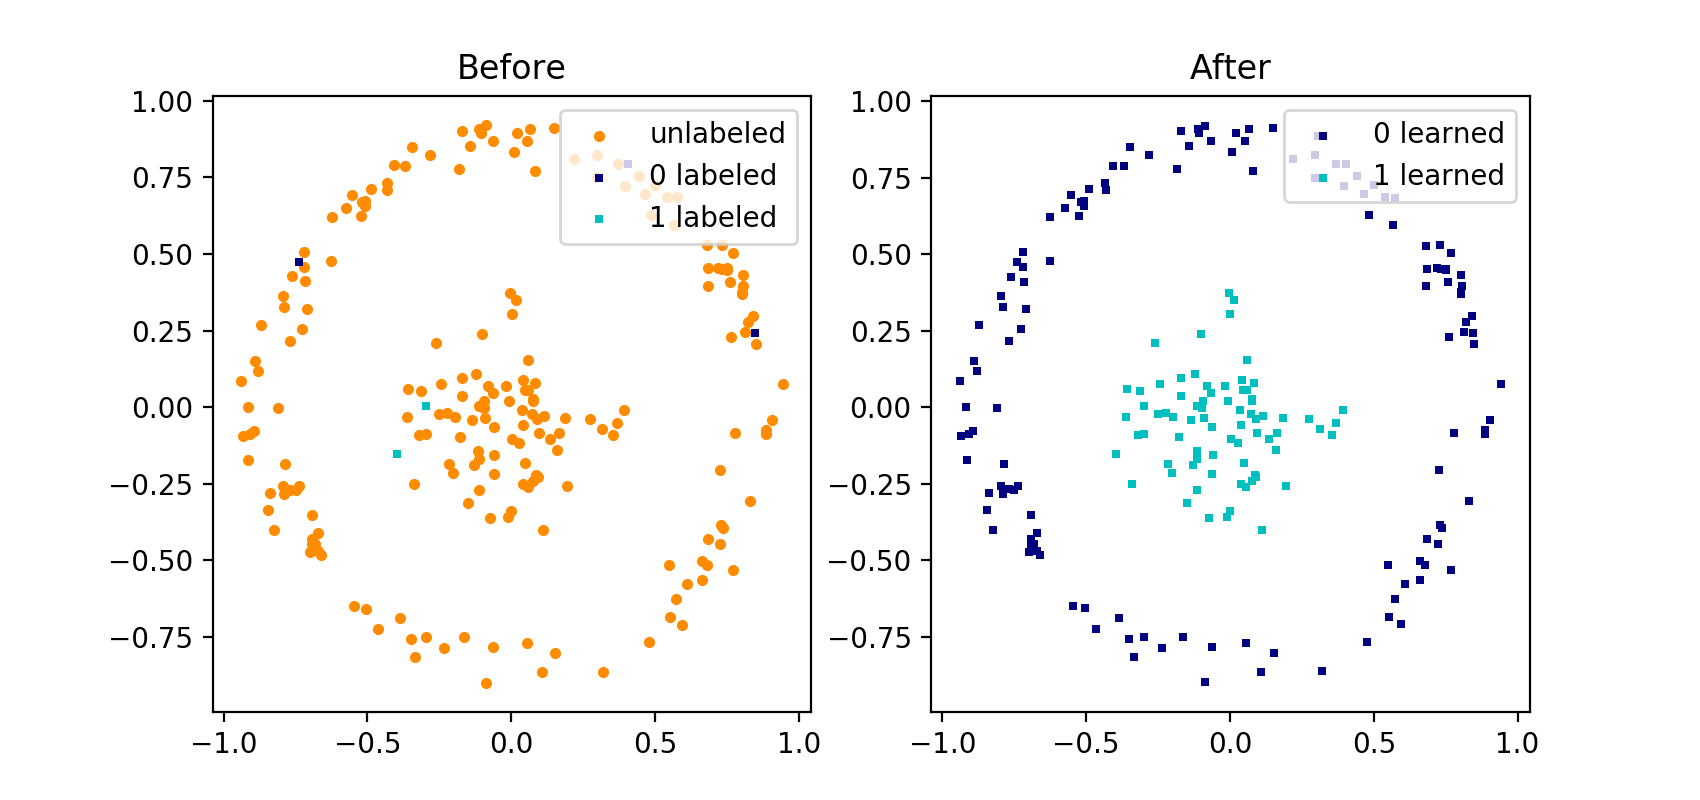

In [153]:
run('bullseye', 0.02)

<IPython.core.display.Javascript object>


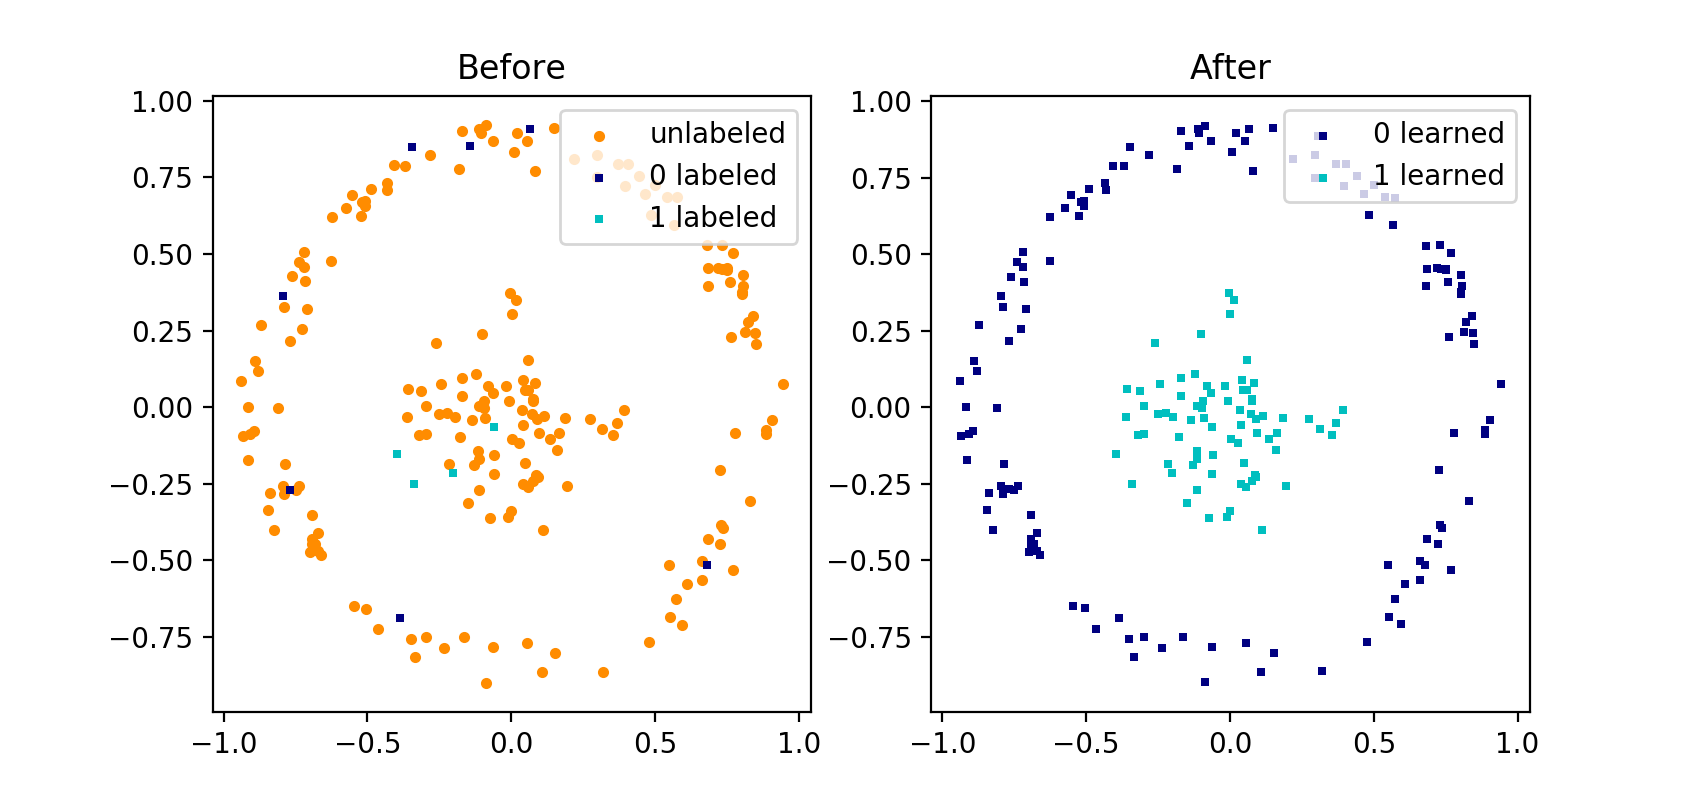

In [154]:
run('bullseye', 0.05)

<IPython.core.display.Javascript object>


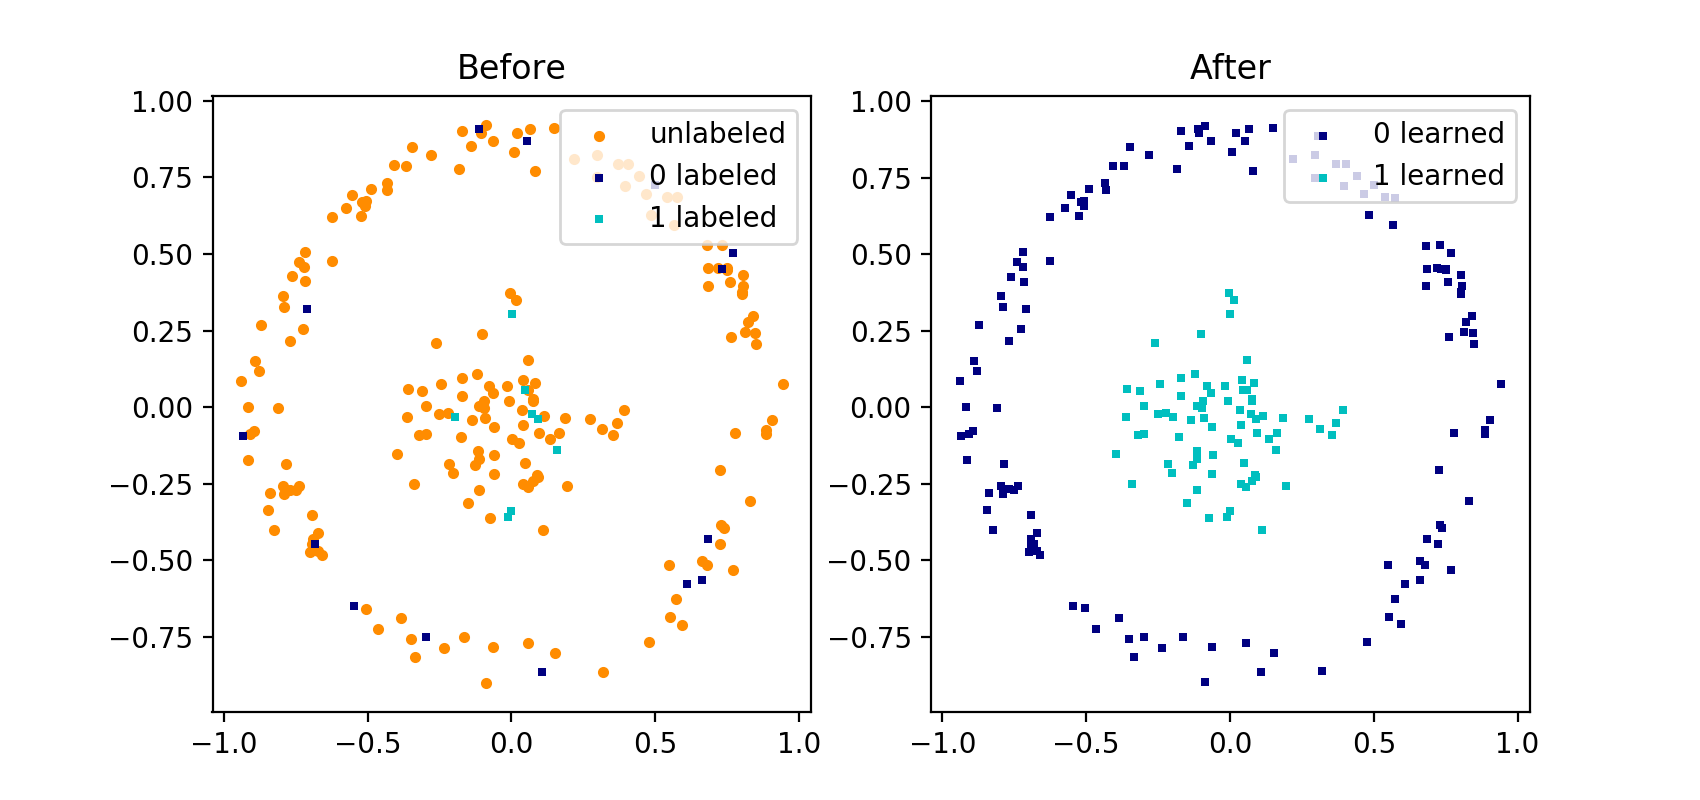

In [155]:
run('bullseye', 0.1)

<IPython.core.display.Javascript object>


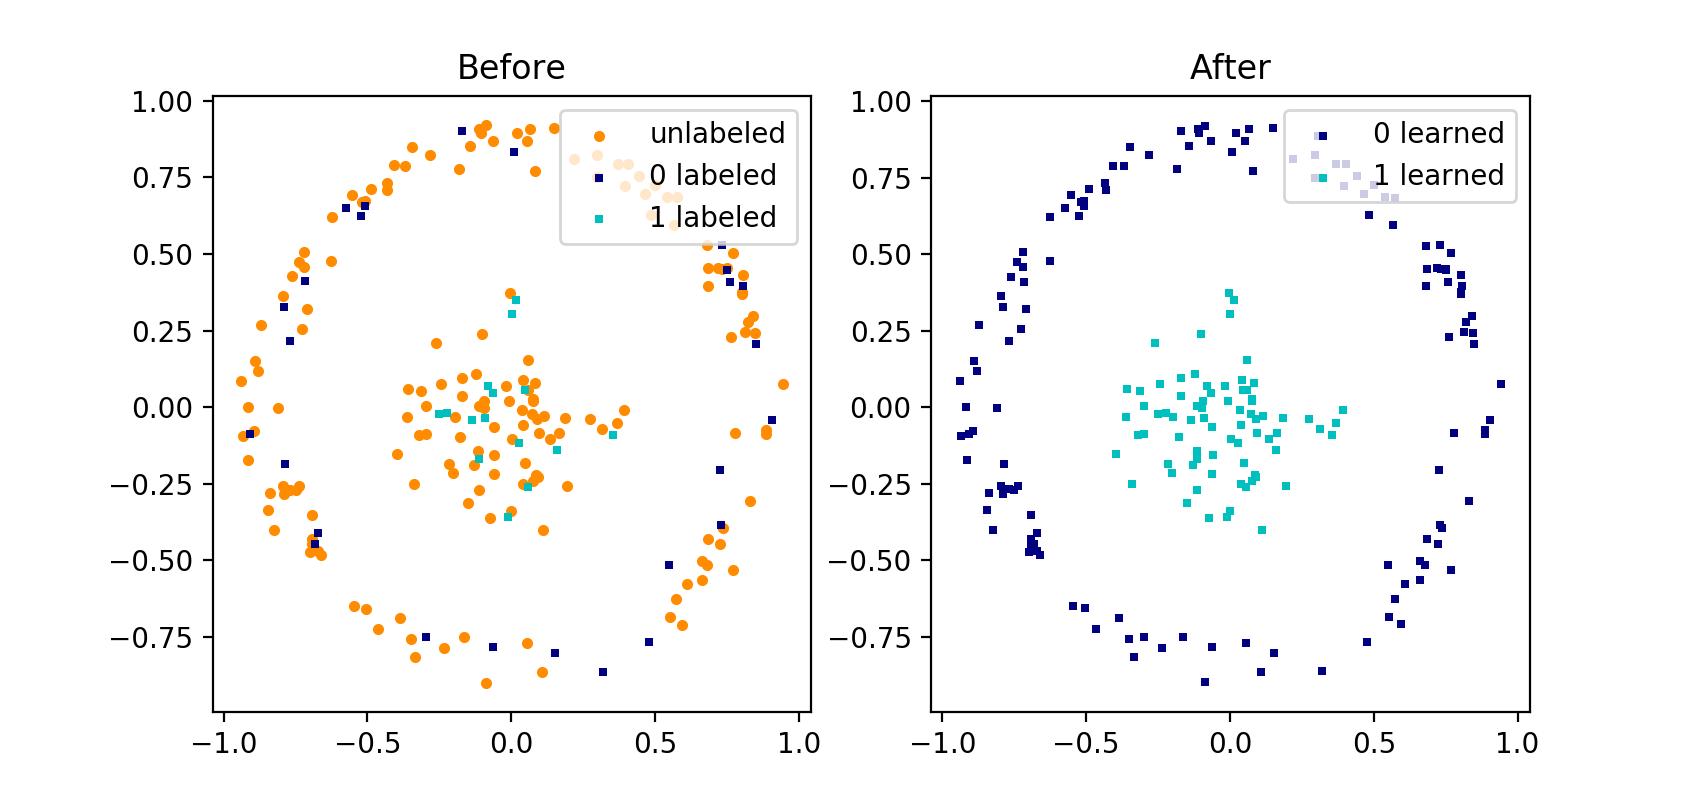

In [156]:
run('bullseye', 0.2)

<IPython.core.display.Javascript object>


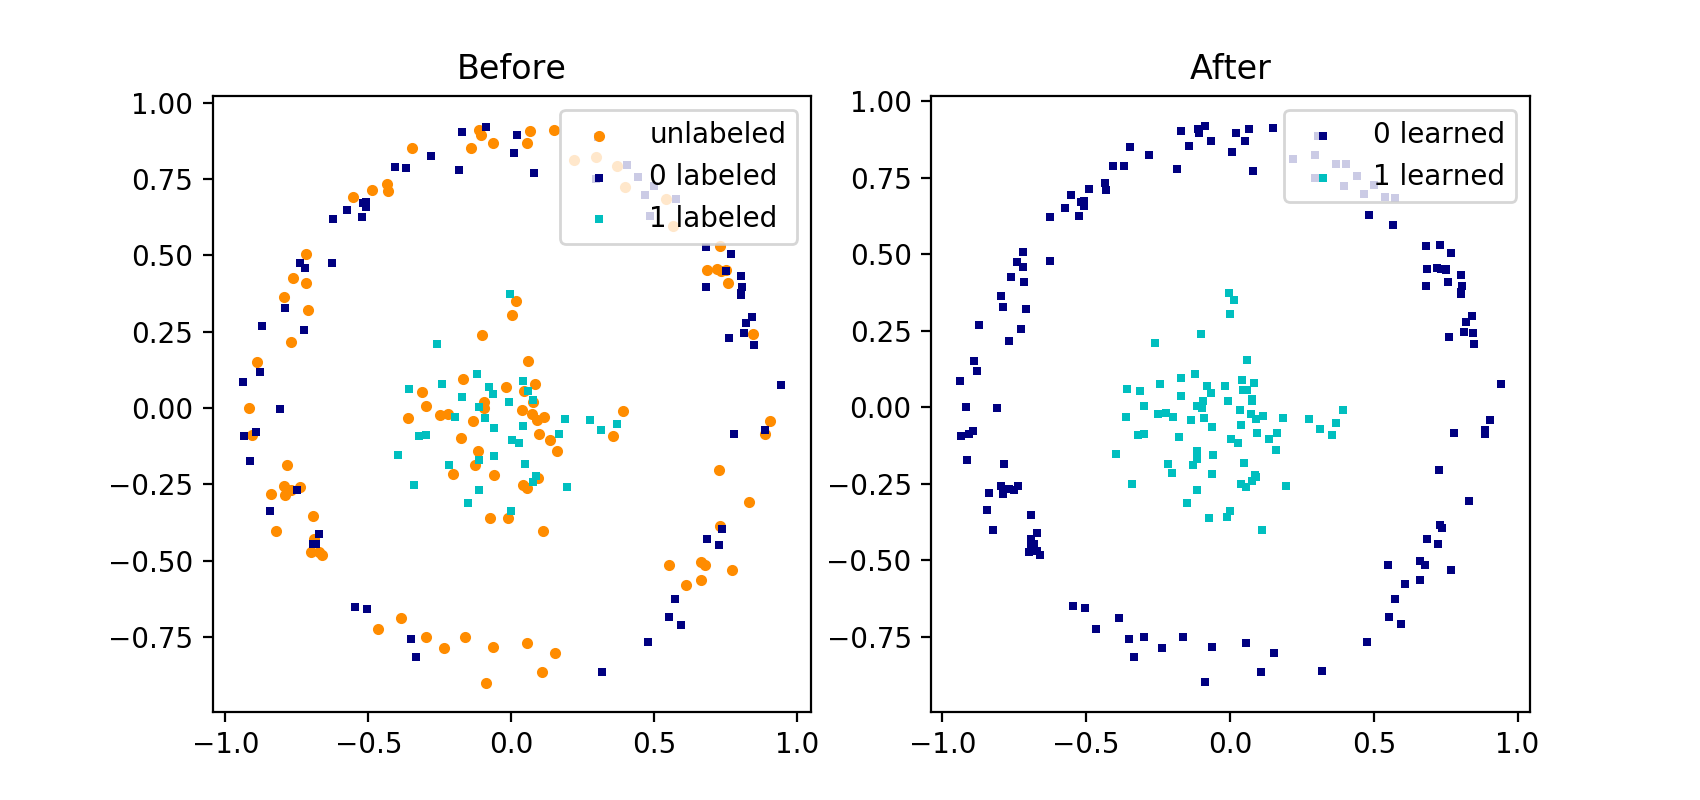

In [157]:
run('bullseye', 0.5)

## - Data 1

<IPython.core.display.Javascript object>


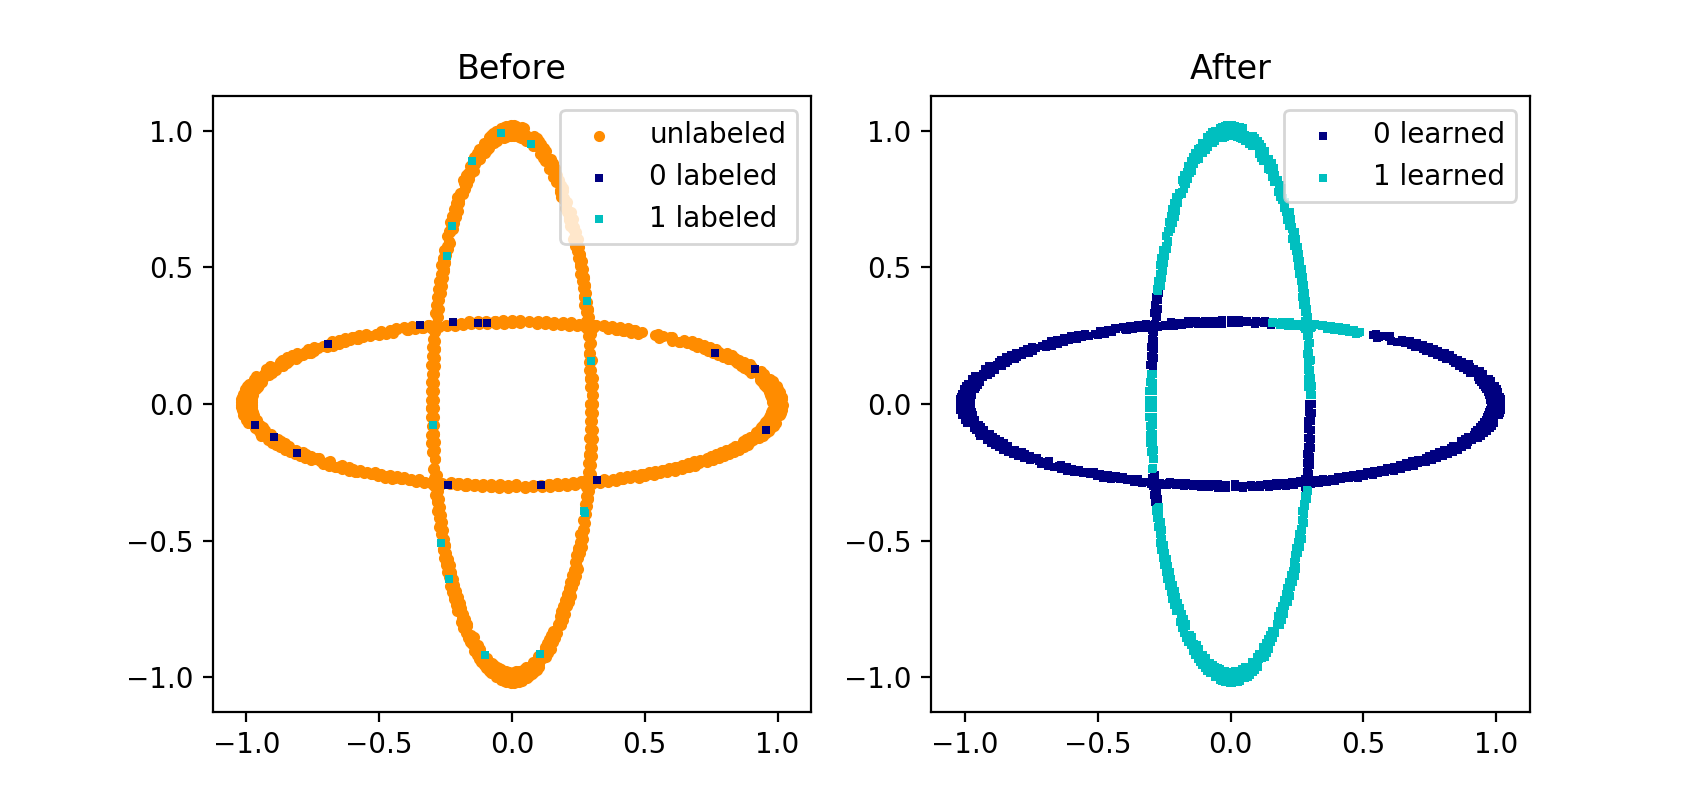

In [158]:
run('Data1', 0.02)

<IPython.core.display.Javascript object>


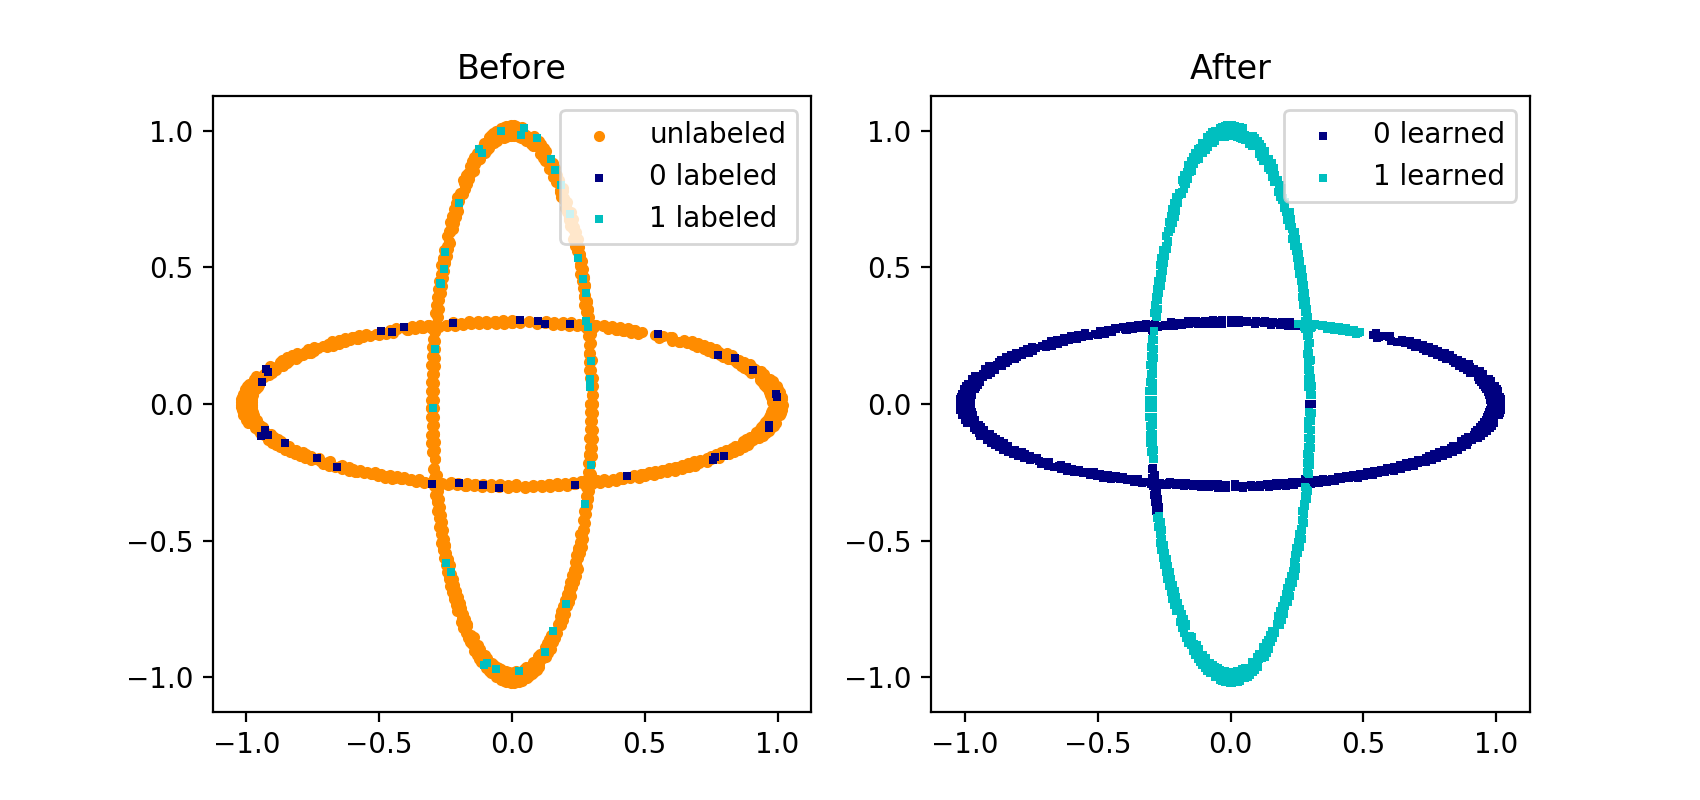

In [159]:
run('Data1', 0.05)

<IPython.core.display.Javascript object>


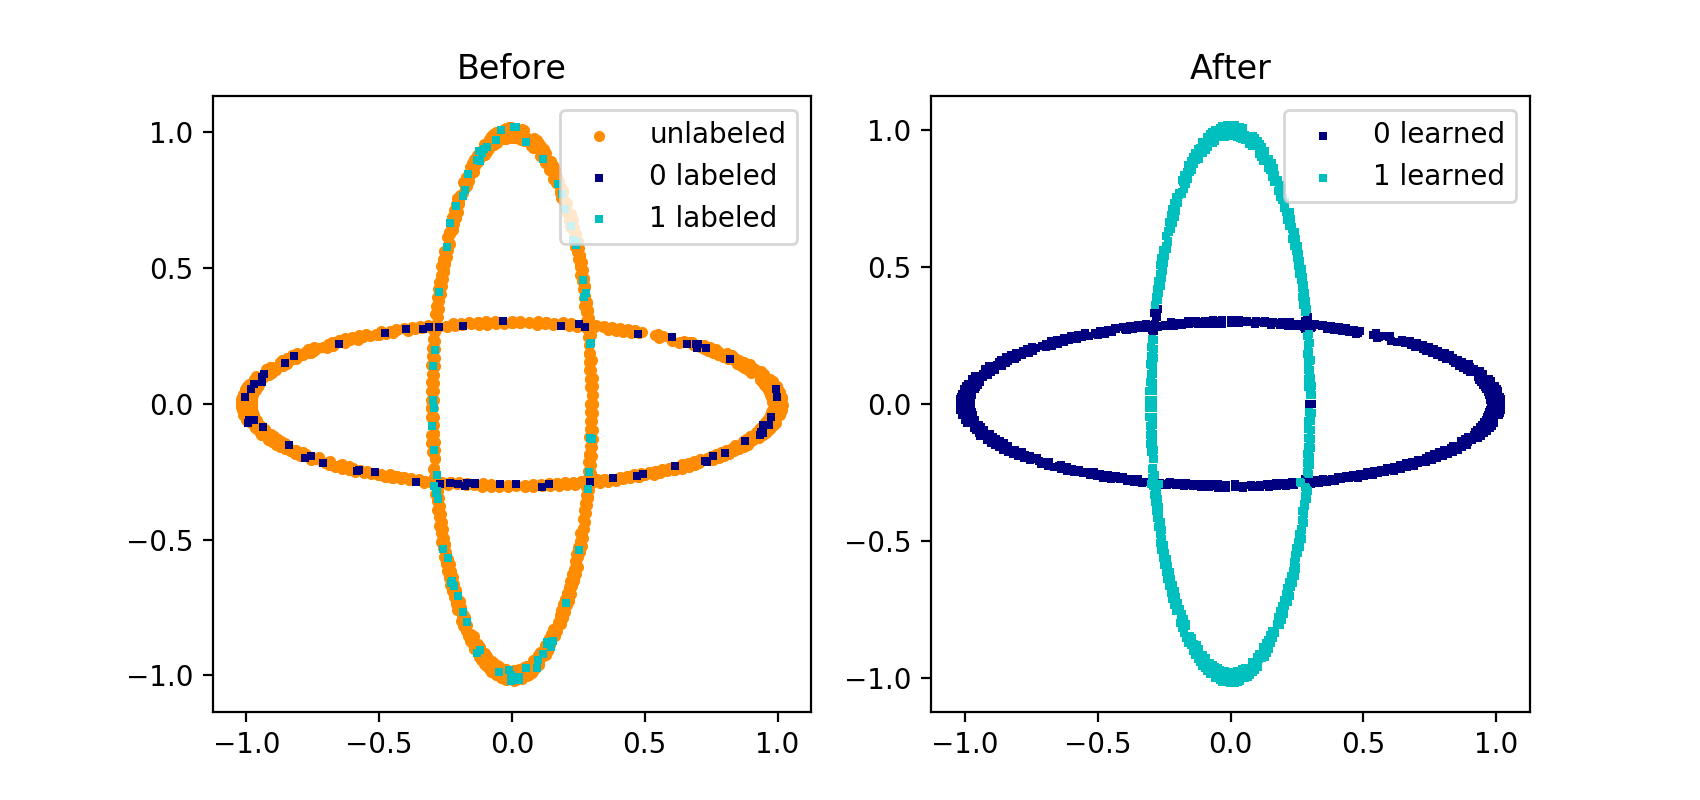

In [160]:
run('Data1', 0.1)

<IPython.core.display.Javascript object>


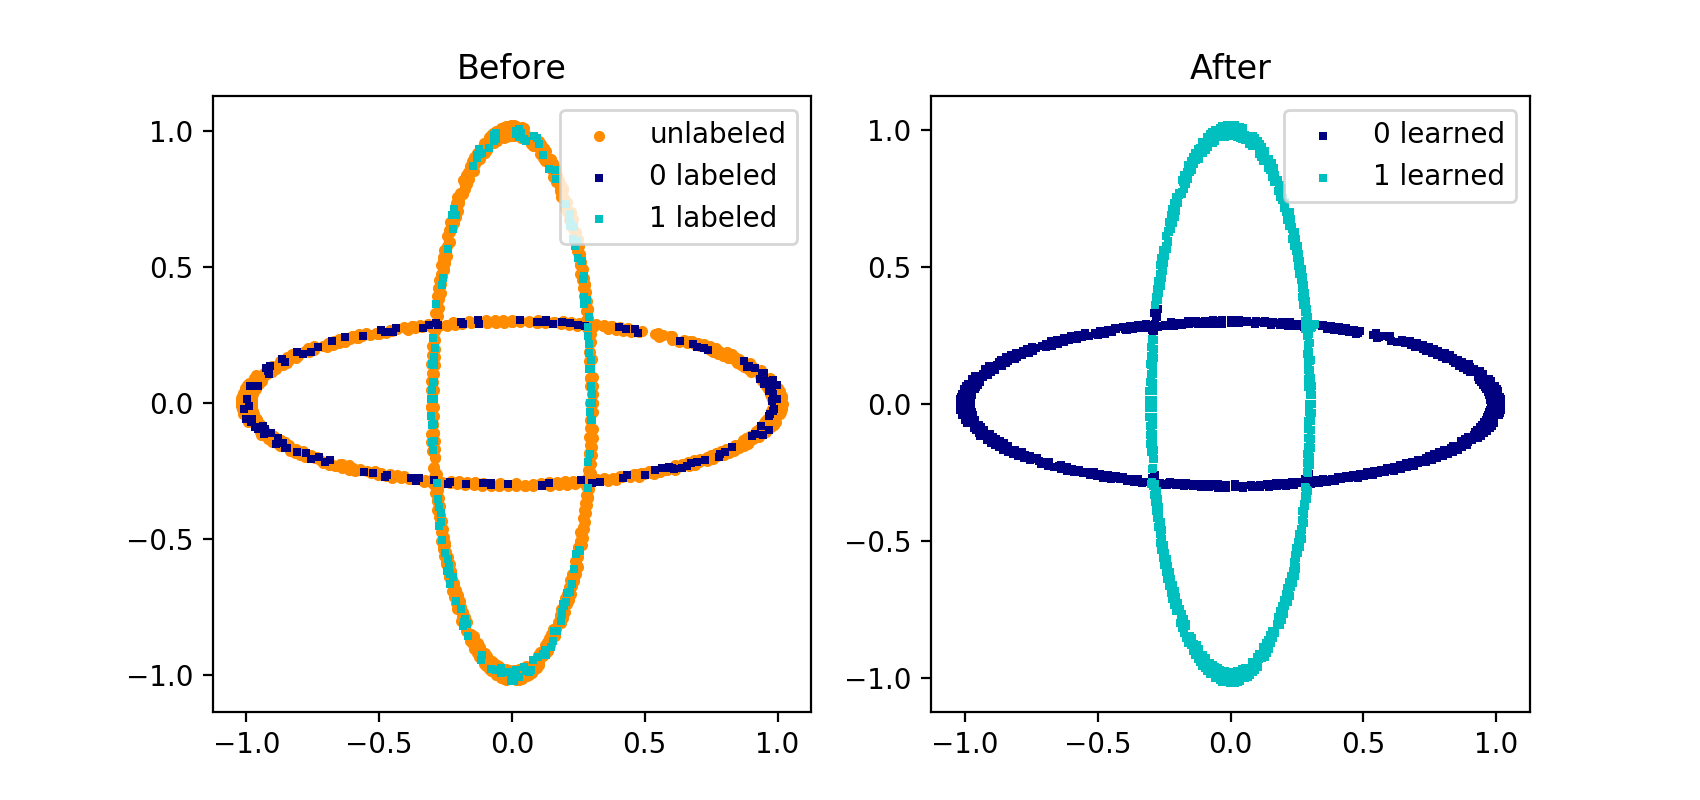

In [161]:
run('Data1', 0.2)

<IPython.core.display.Javascript object>


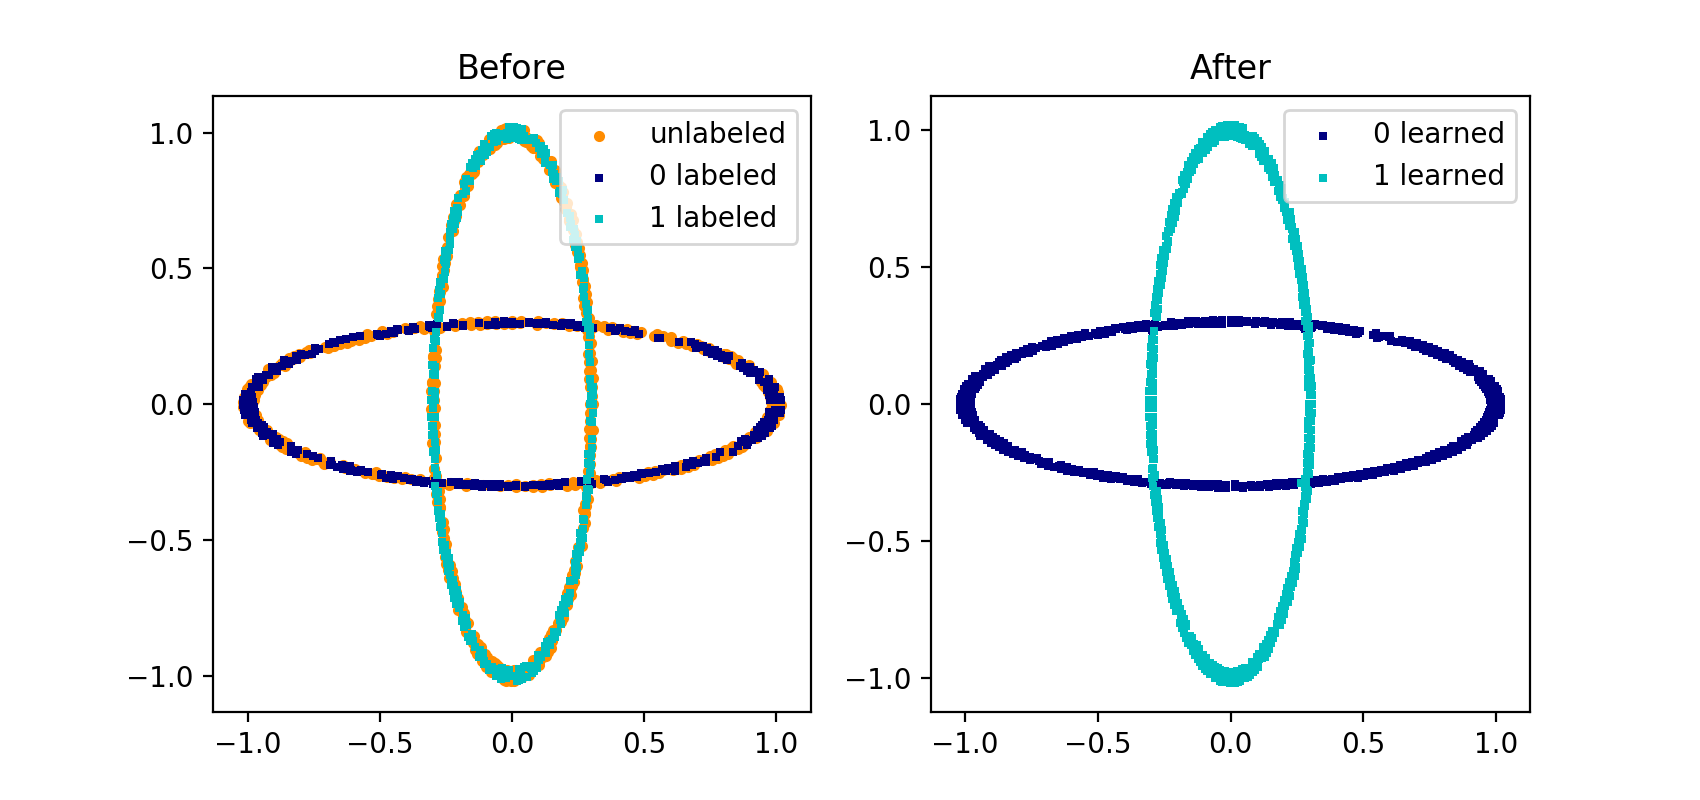

In [162]:
run('Data1', 0.5)

## - Data2

<IPython.core.display.Javascript object>


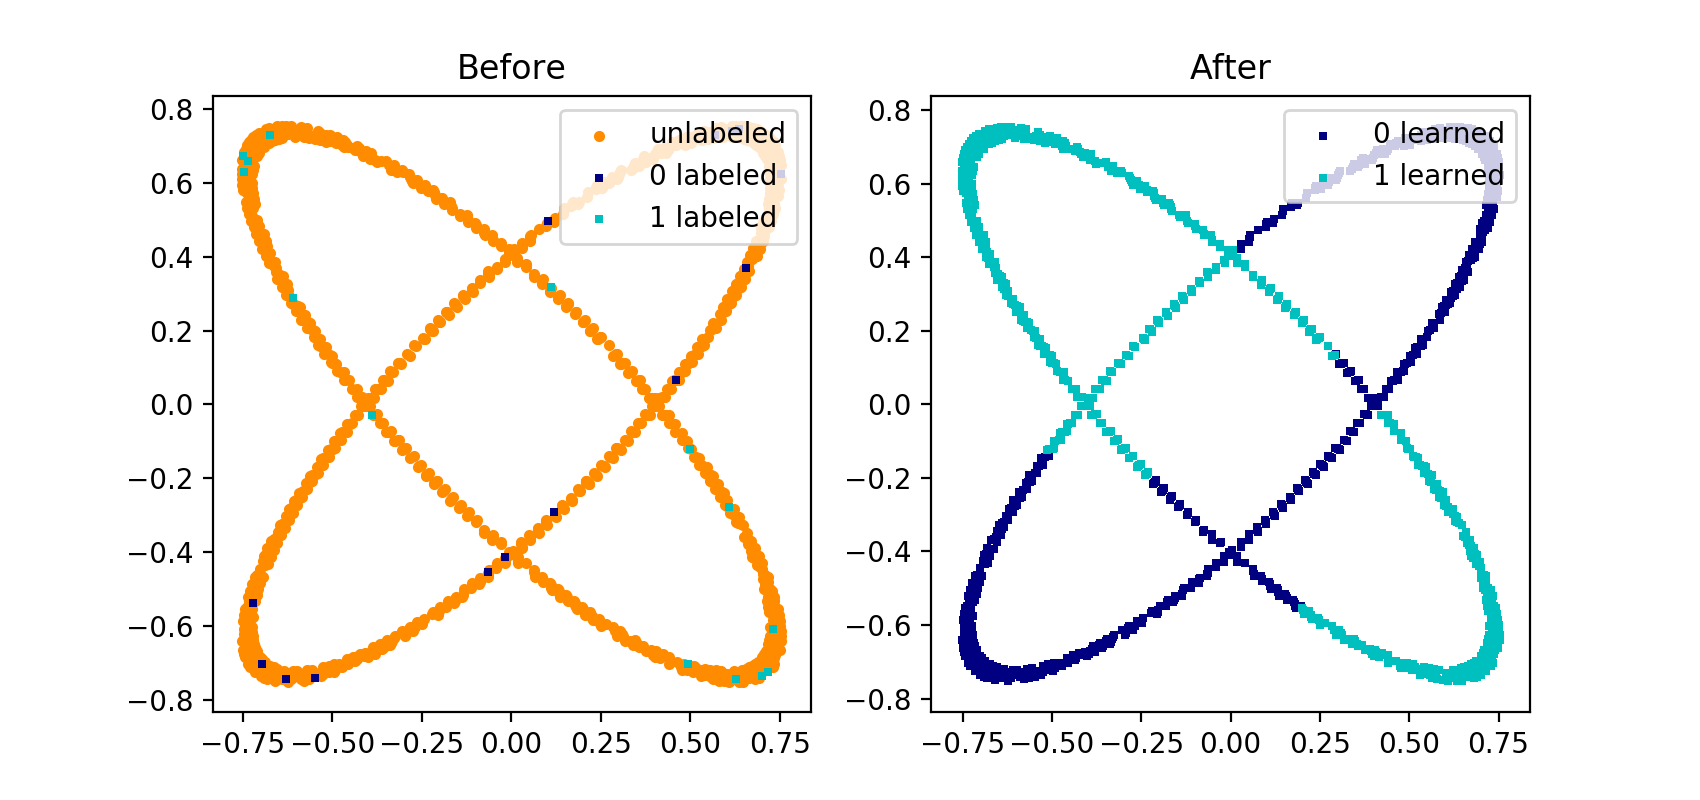

In [163]:
run('Data2', 0.02)

<IPython.core.display.Javascript object>


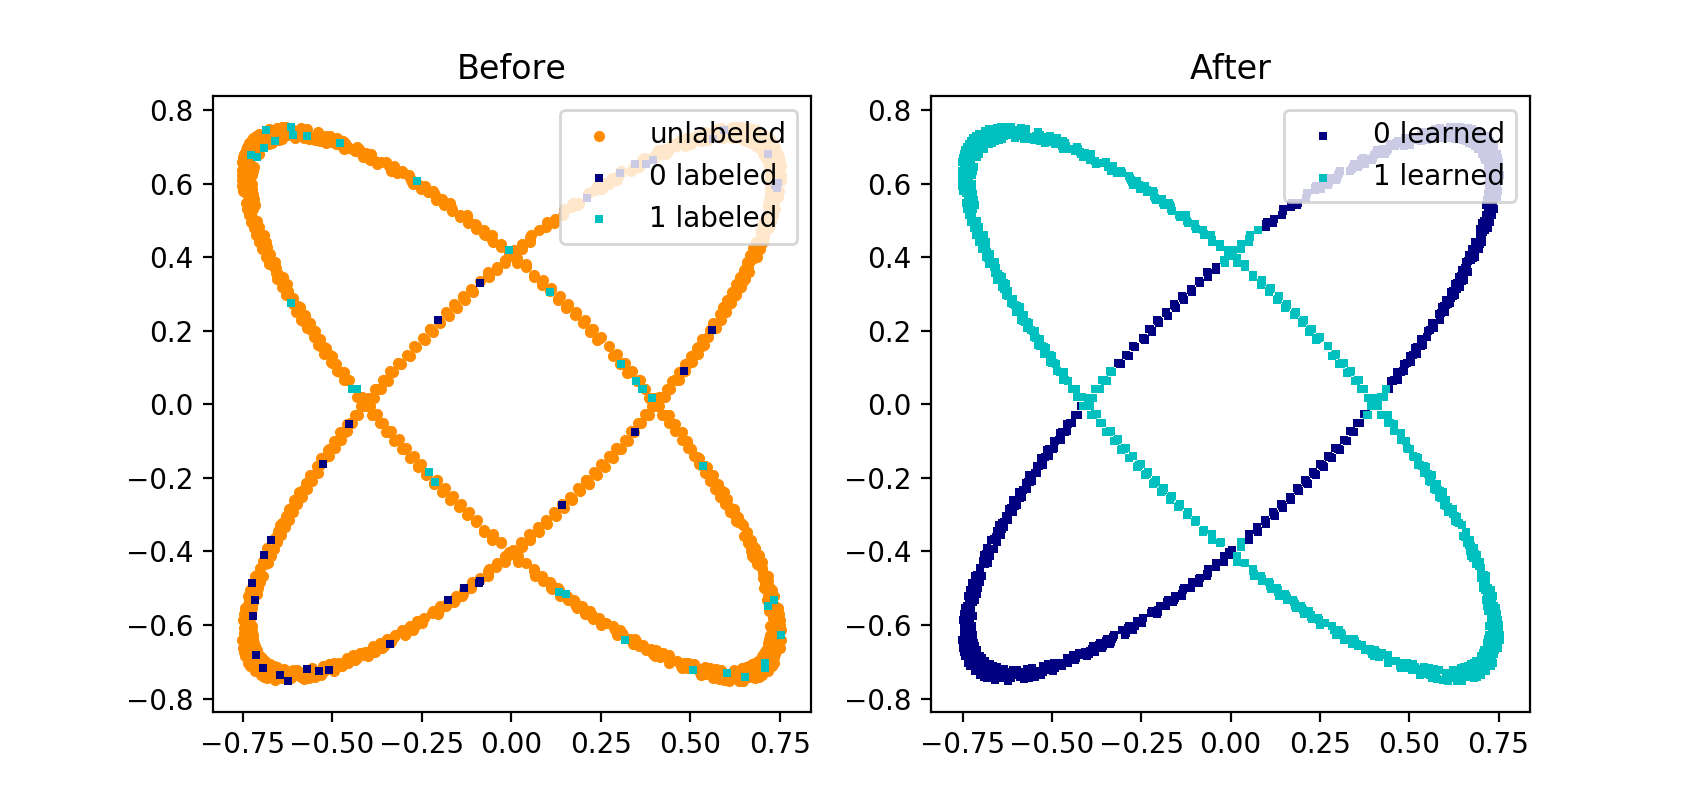

In [164]:
run('Data2', 0.05)

<IPython.core.display.Javascript object>


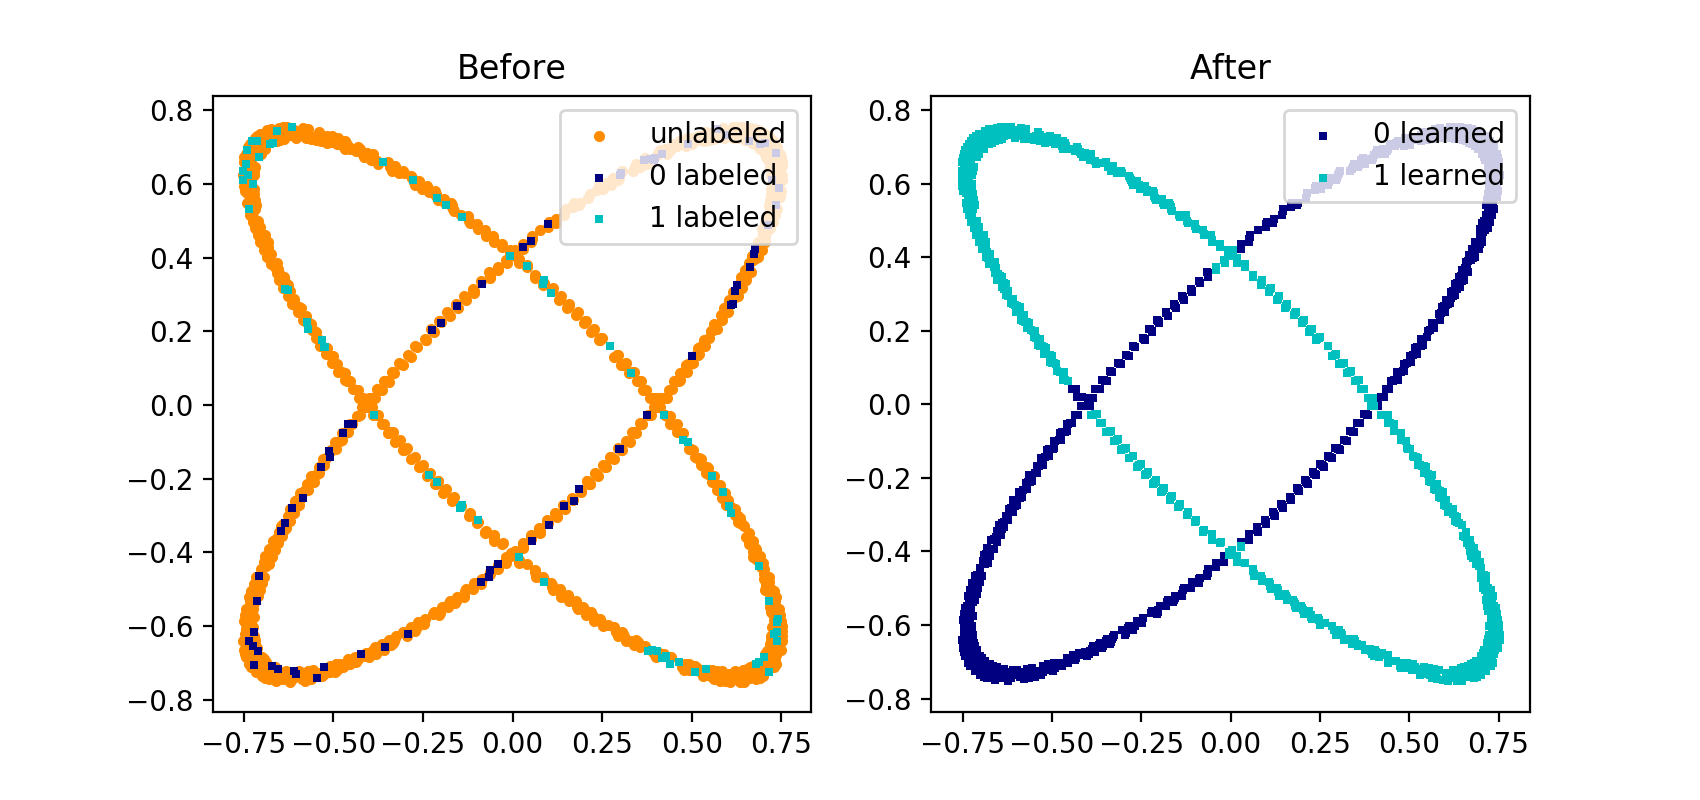

In [165]:
run('Data2', 0.1)

<IPython.core.display.Javascript object>


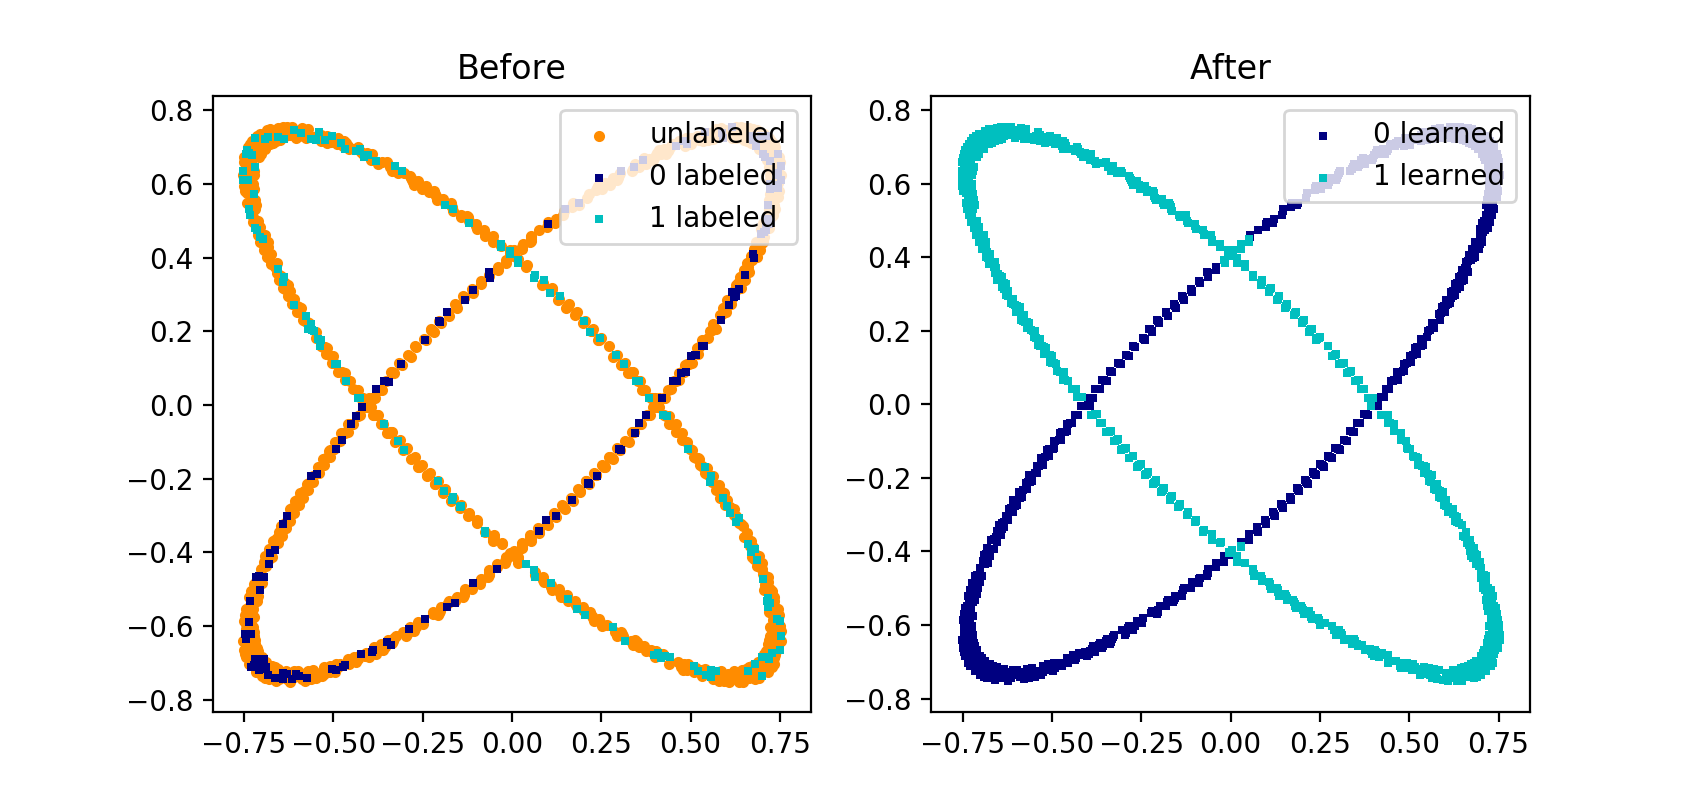

In [166]:
run('Data2', 0.2)

<IPython.core.display.Javascript object>


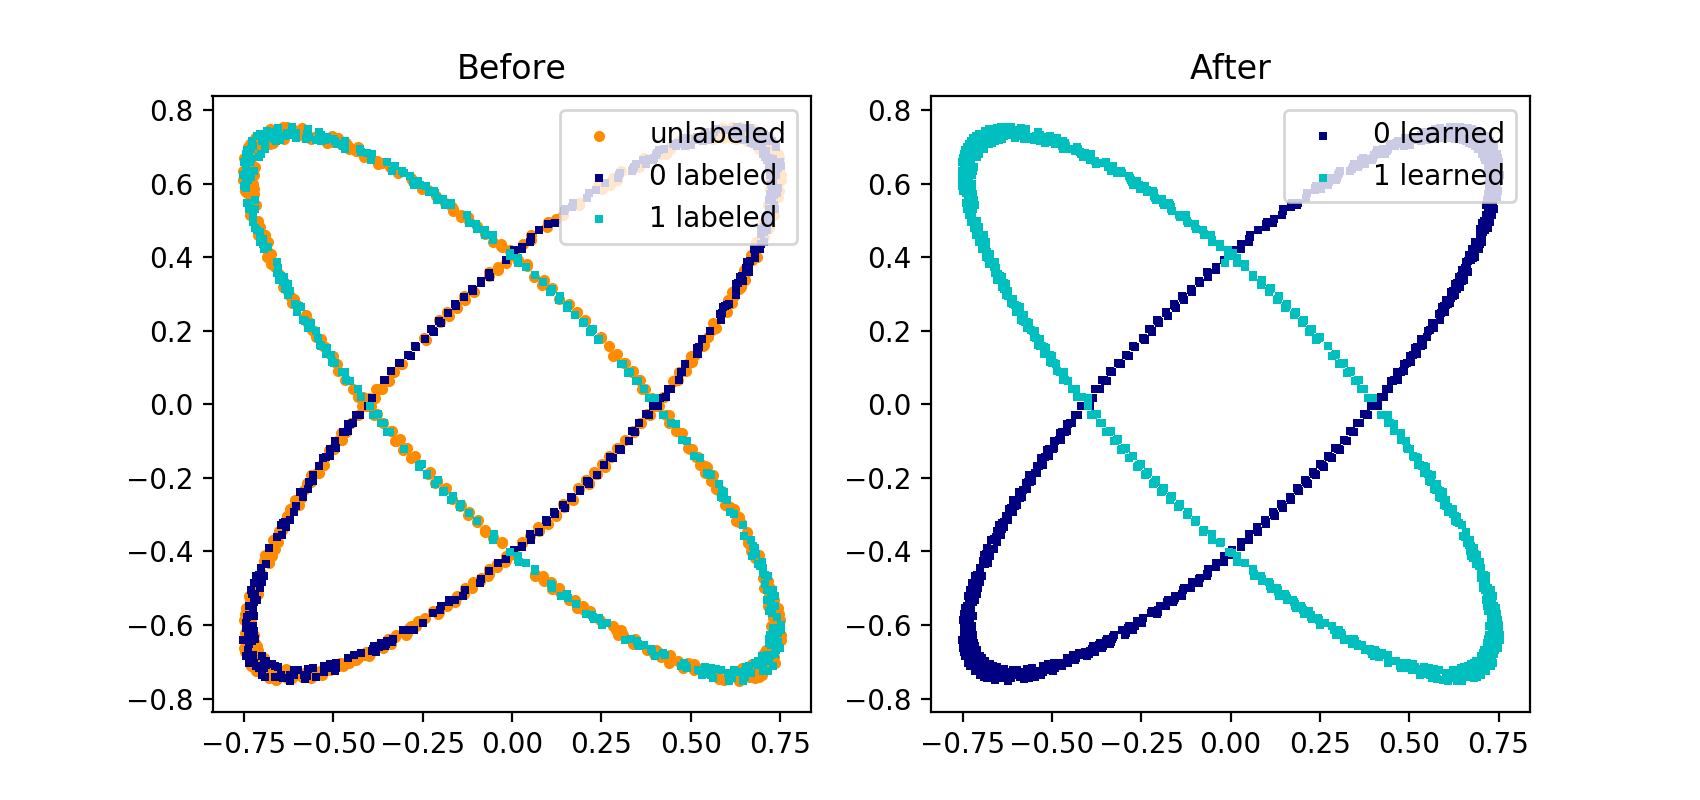

In [167]:
run('Data2', 0.5)

## - Data3

<IPython.core.display.Javascript object>


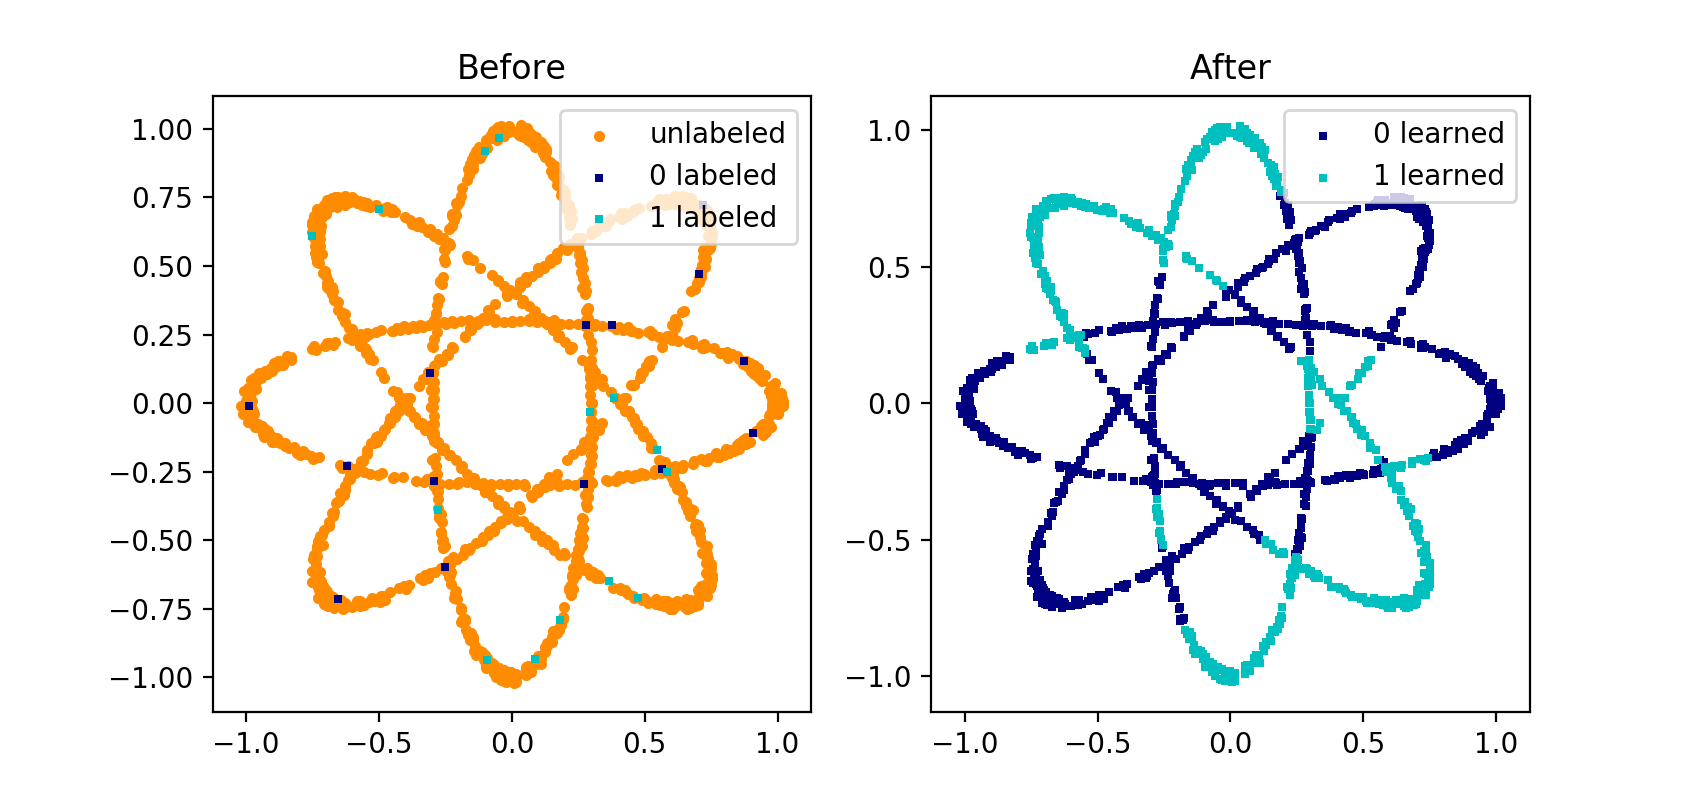

In [168]:
run('Data3', 0.02)

<IPython.core.display.Javascript object>


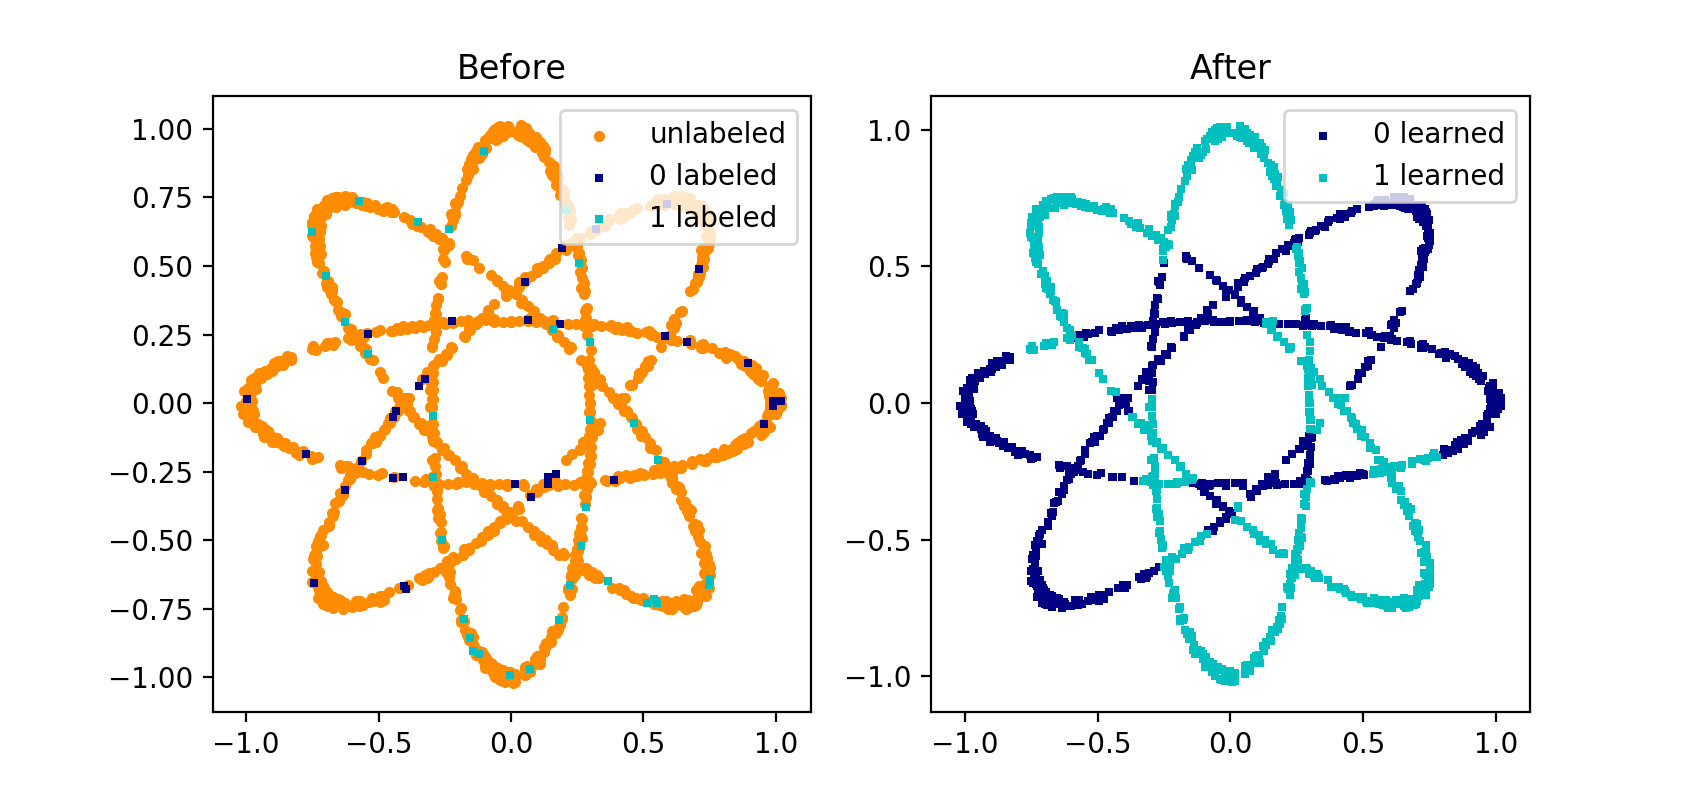

In [169]:
run('Data3', 0.05)

<IPython.core.display.Javascript object>


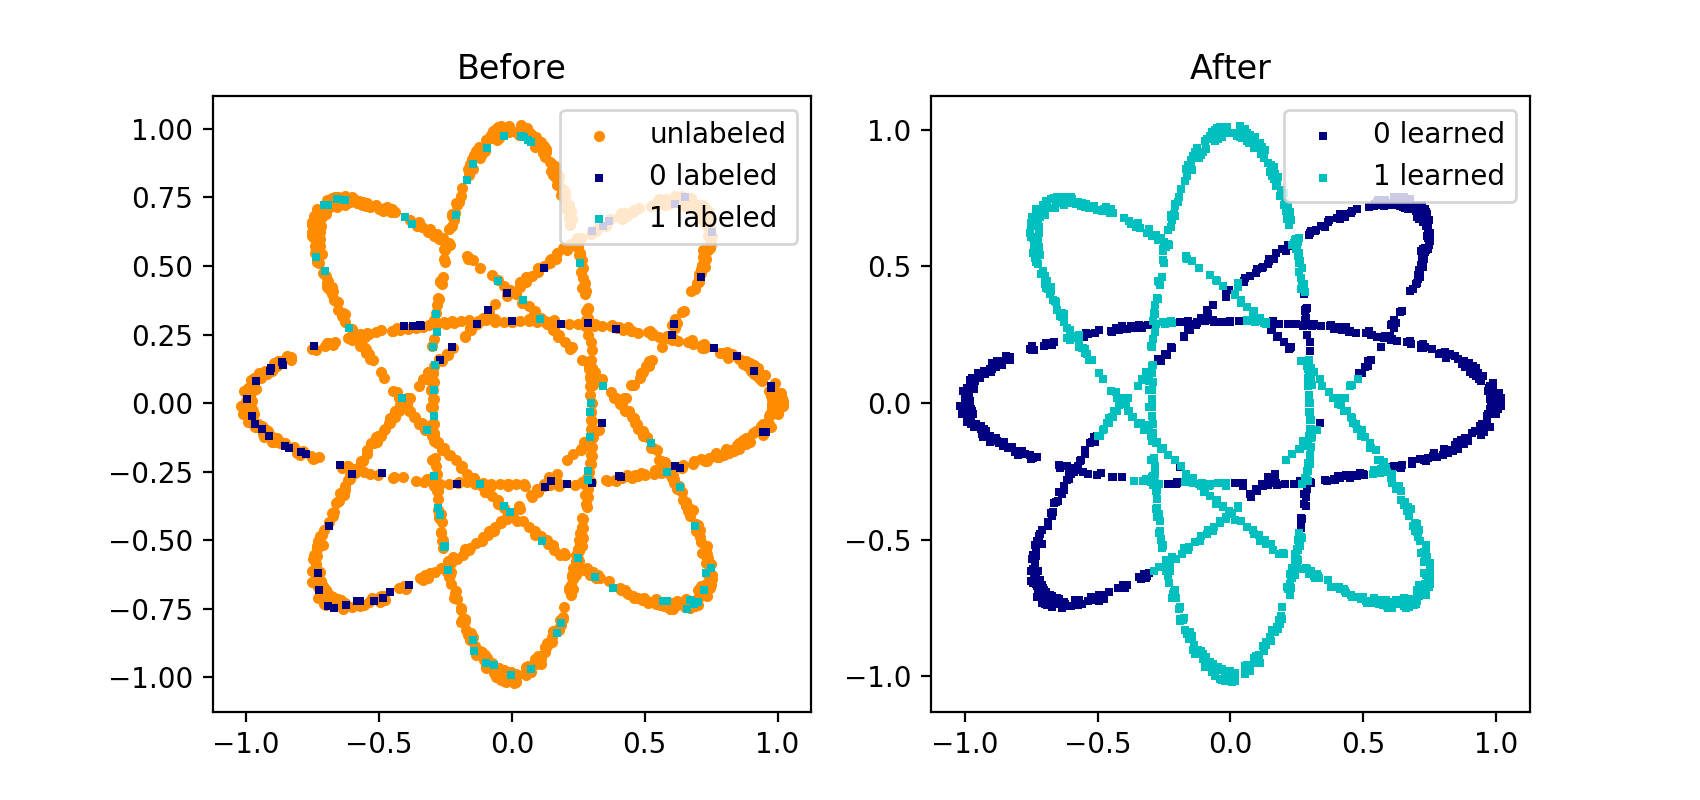

In [170]:
run('Data3', 0.1)

<IPython.core.display.Javascript object>


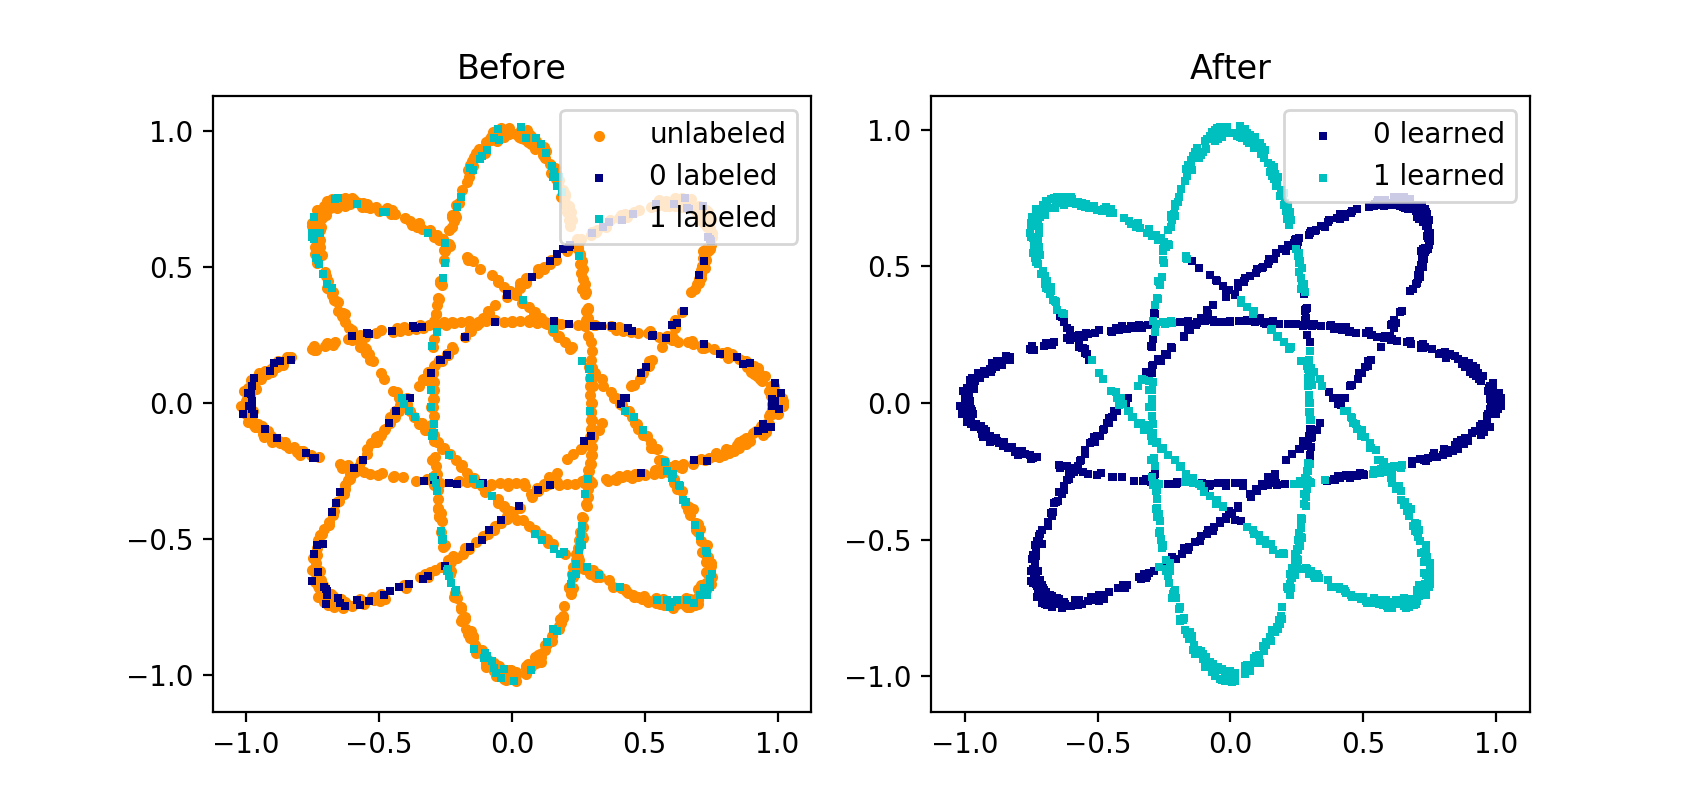

In [171]:
run('Data3', 0.2)

<IPython.core.display.Javascript object>


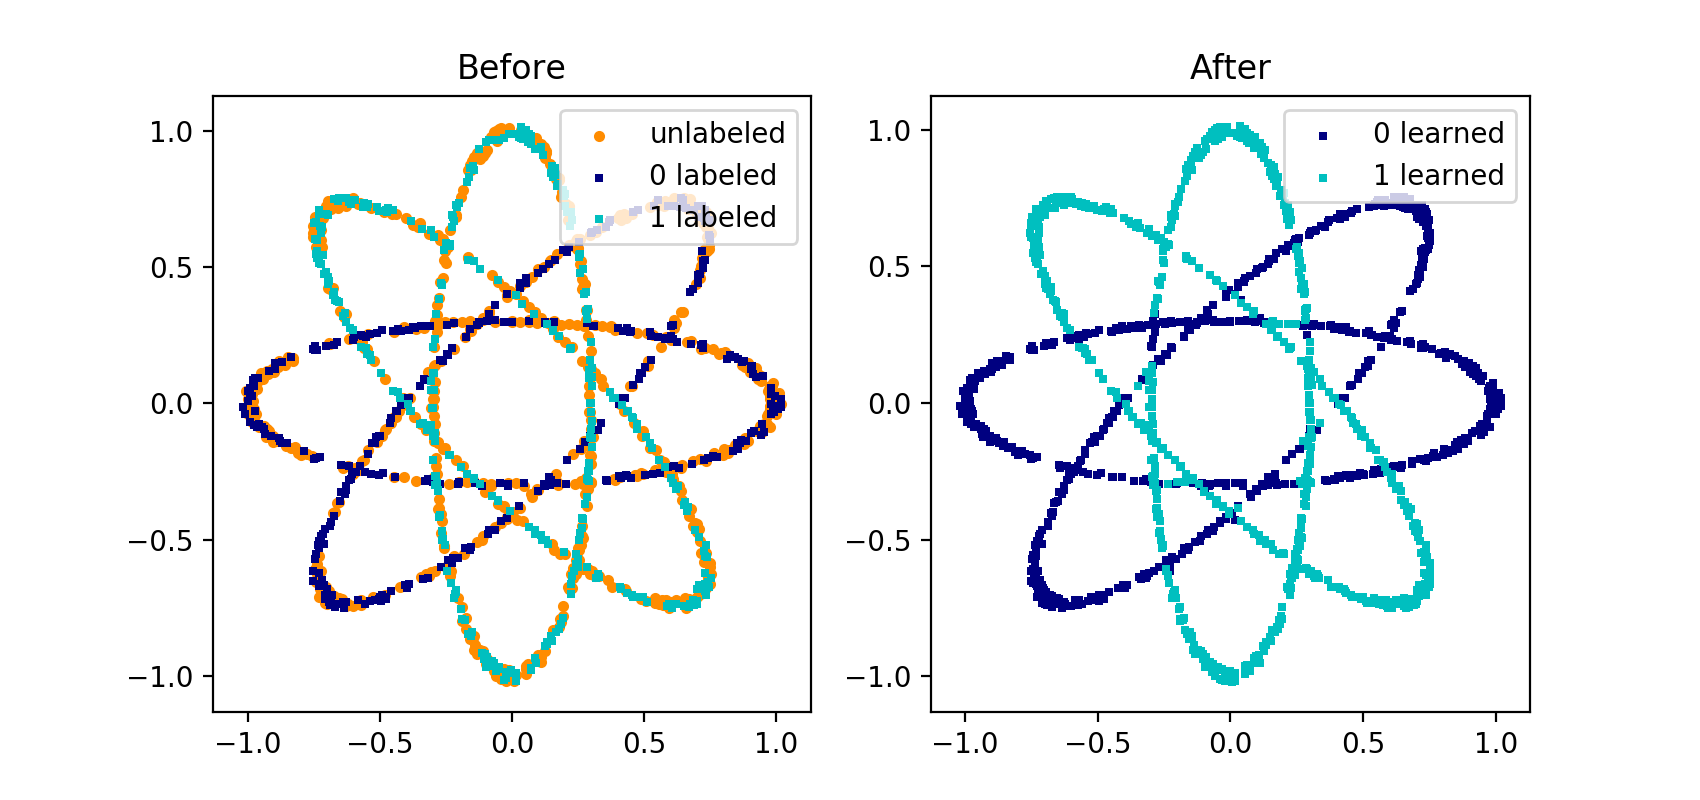

In [172]:
run('Data3', 0.5)

## - impactOfNoise

<IPython.core.display.Javascript object>


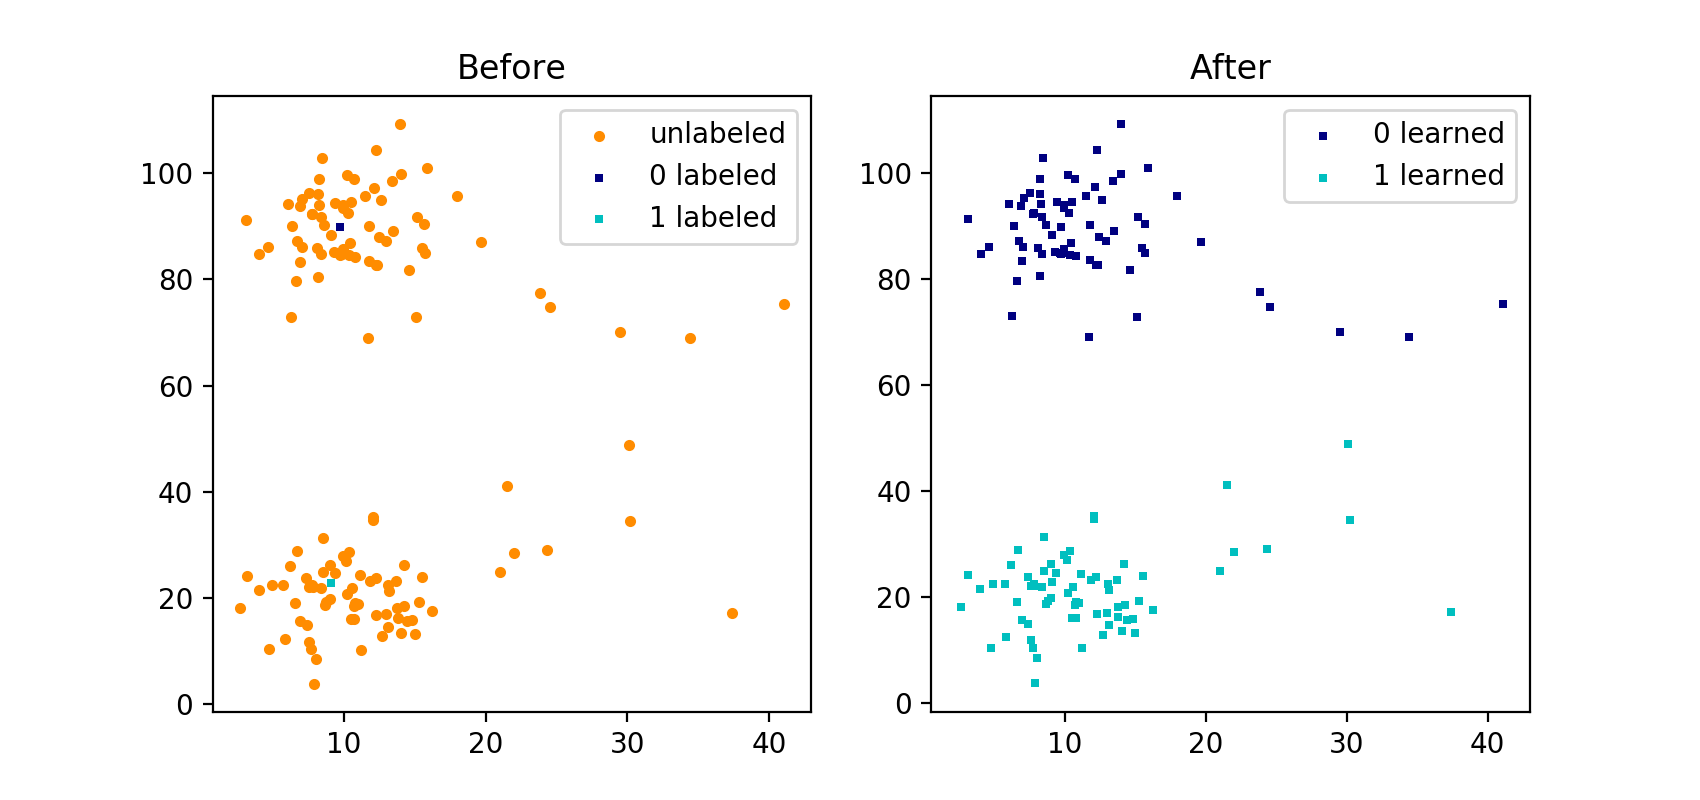

In [173]:
run('impactOfNoise', 0.02)

<IPython.core.display.Javascript object>


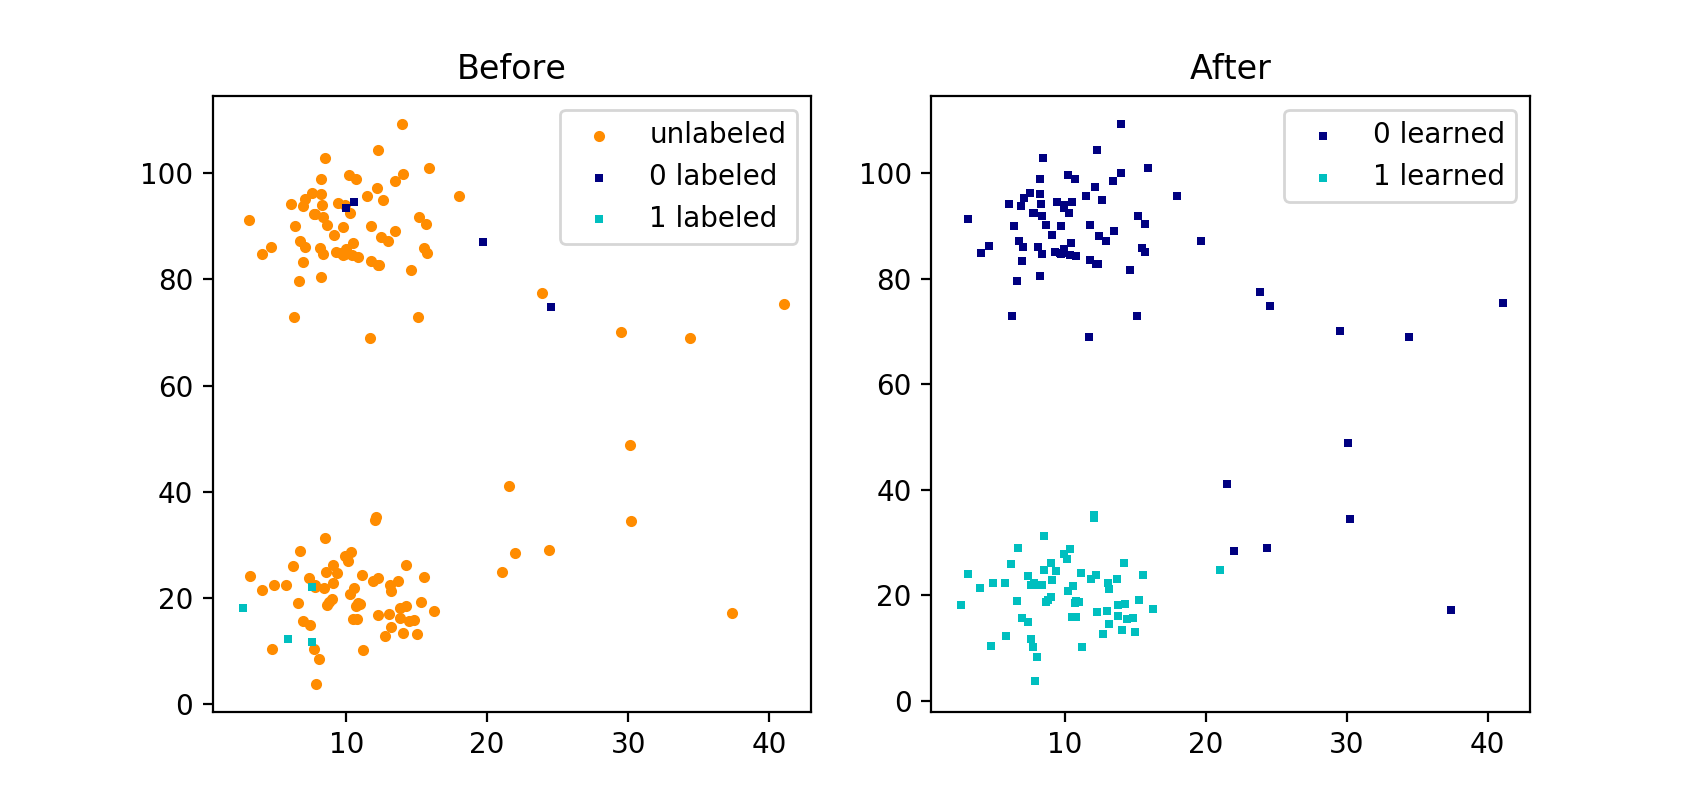

In [174]:
run('impactOfNoise', 0.05)

<IPython.core.display.Javascript object>


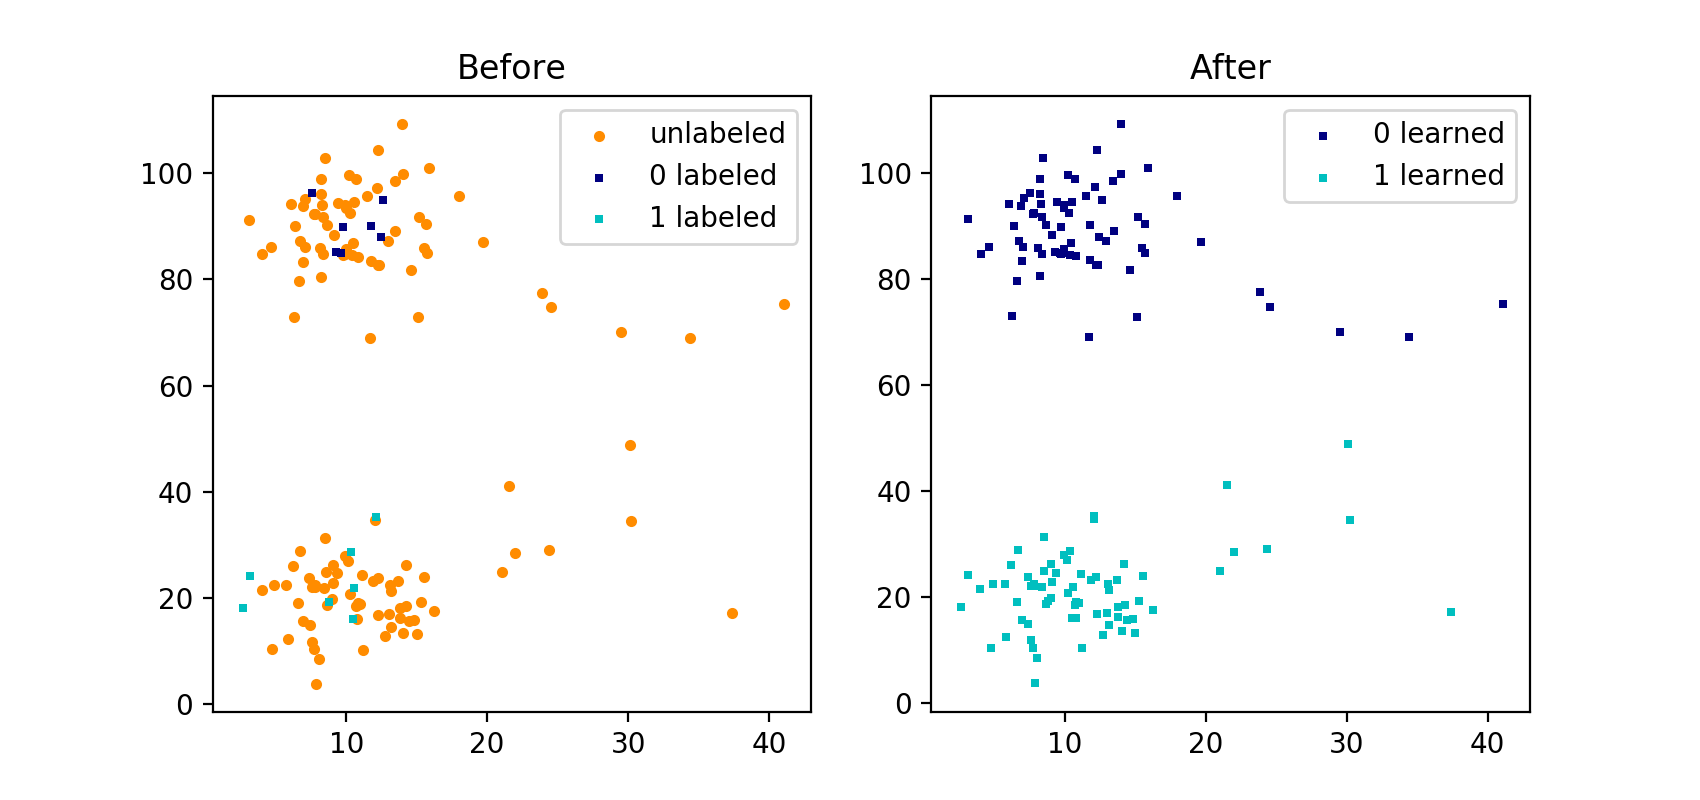

In [175]:
run('impactOfNoise', 0.1)

<IPython.core.display.Javascript object>


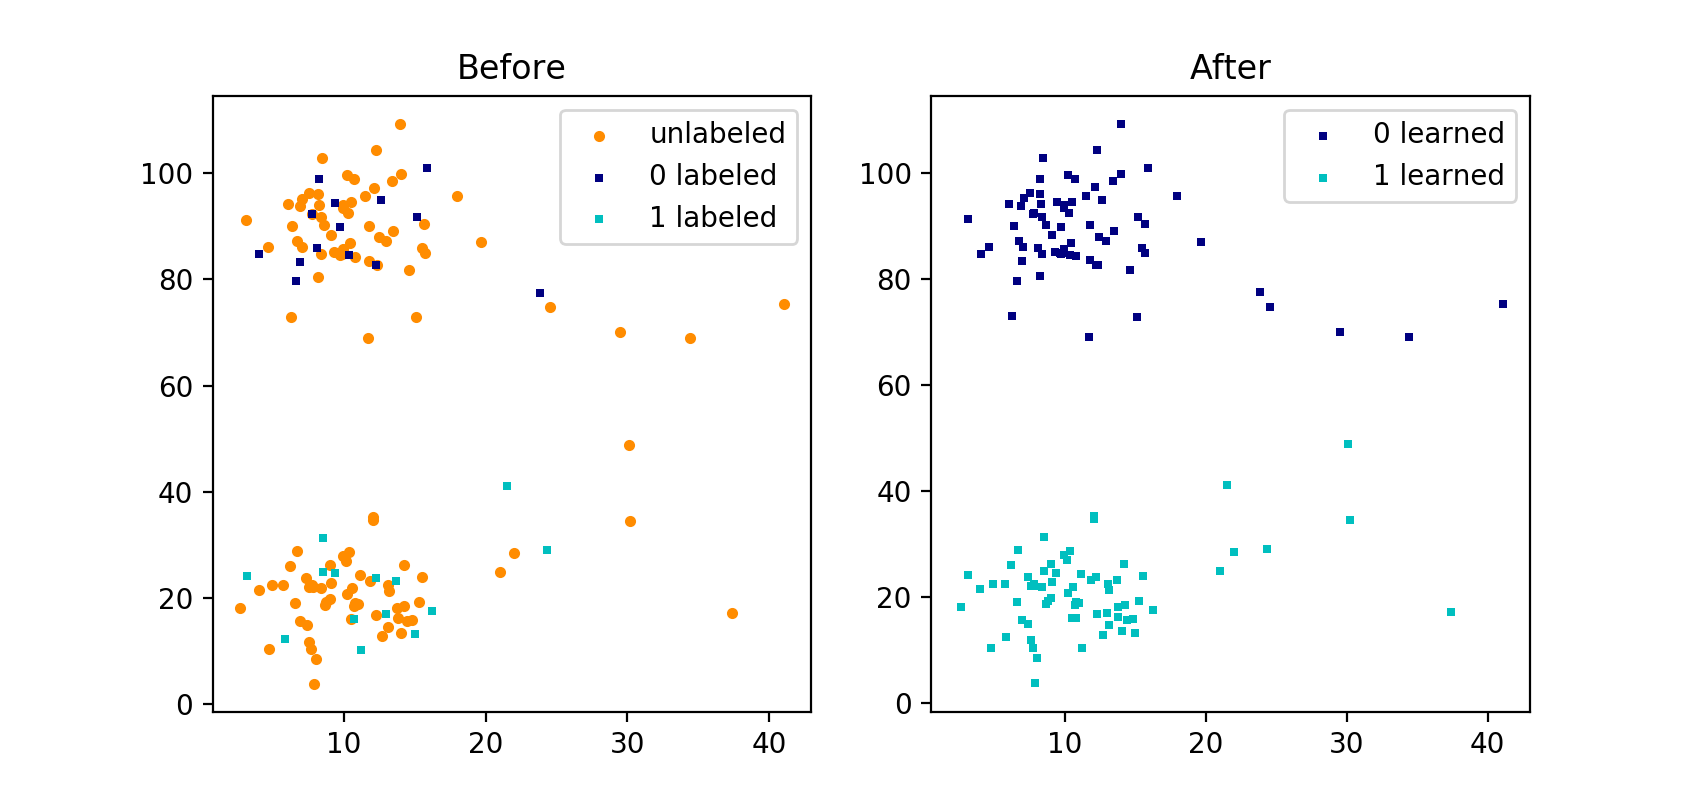

In [176]:
run('impactOfNoise', 0.2)

<IPython.core.display.Javascript object>


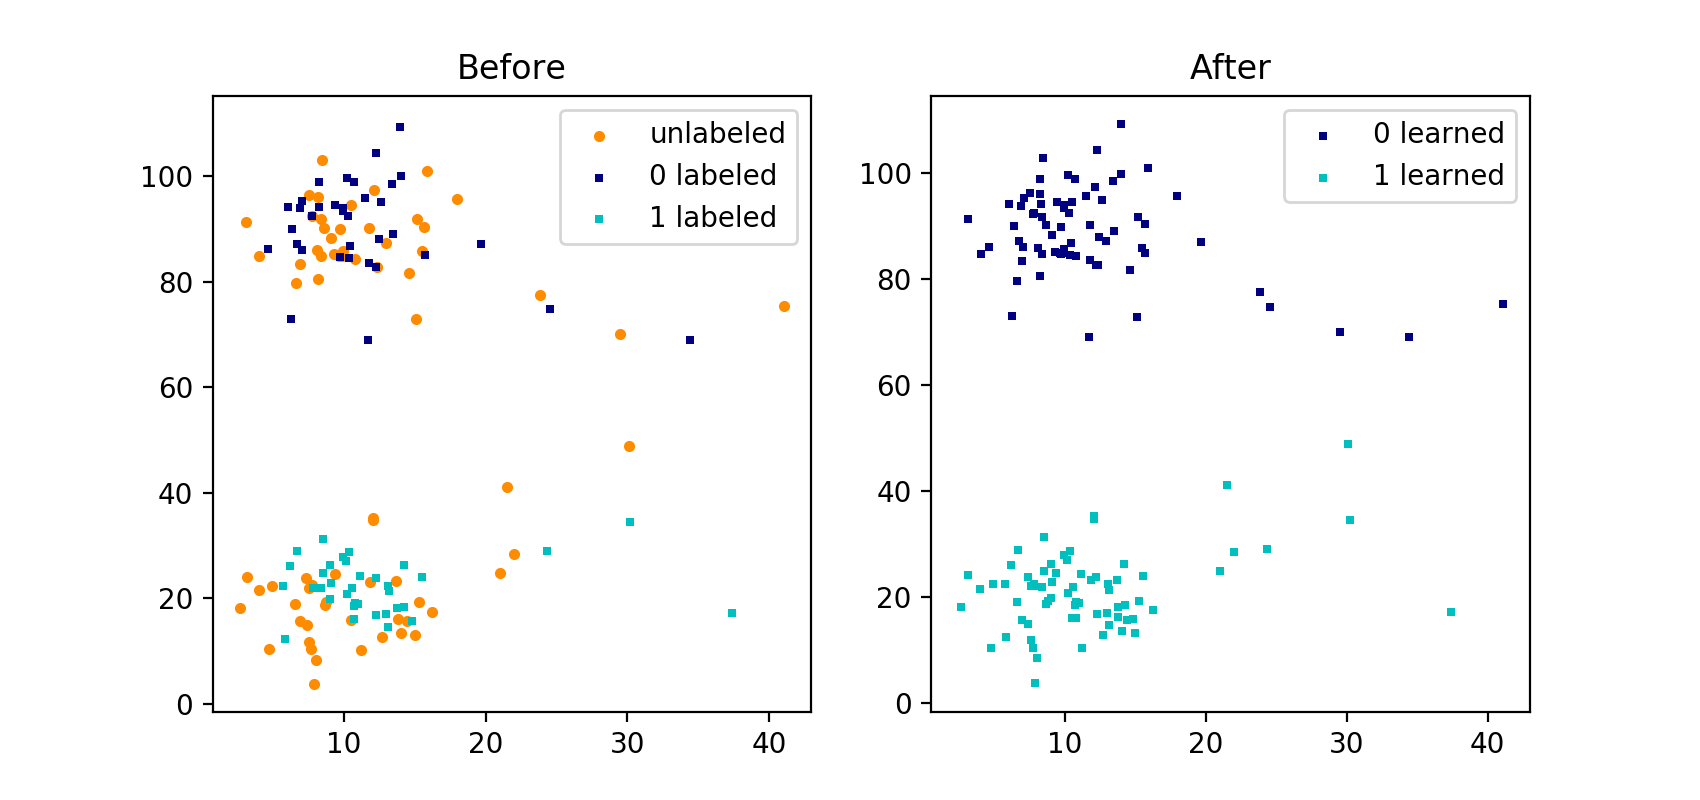

In [177]:
run('impactOfNoise', 0.5)

## - jain

<IPython.core.display.Javascript object>


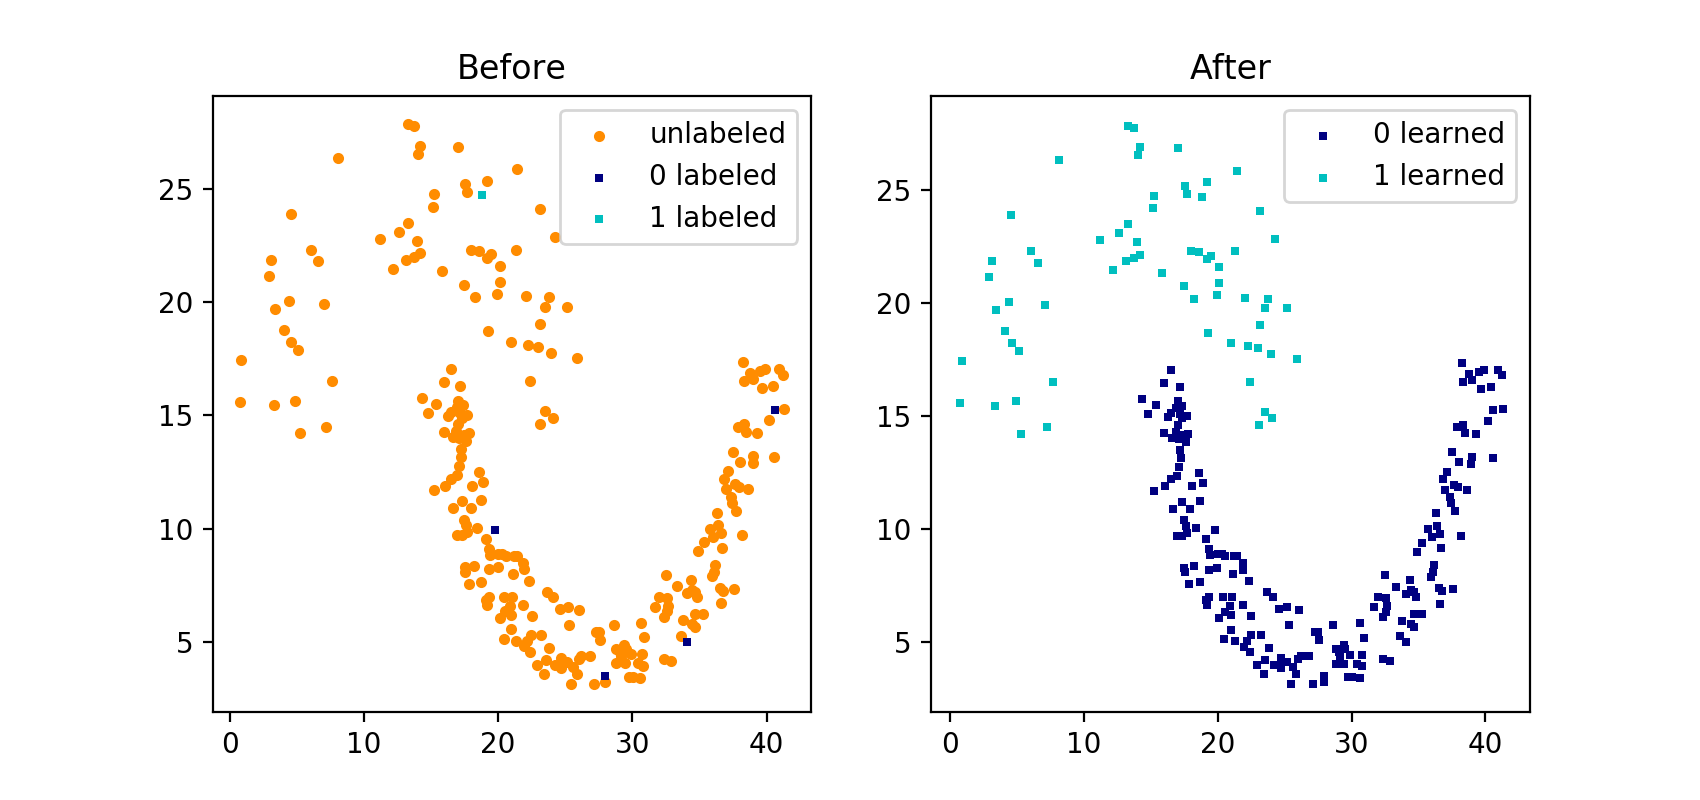

In [178]:
run('jain', 0.02)

<IPython.core.display.Javascript object>


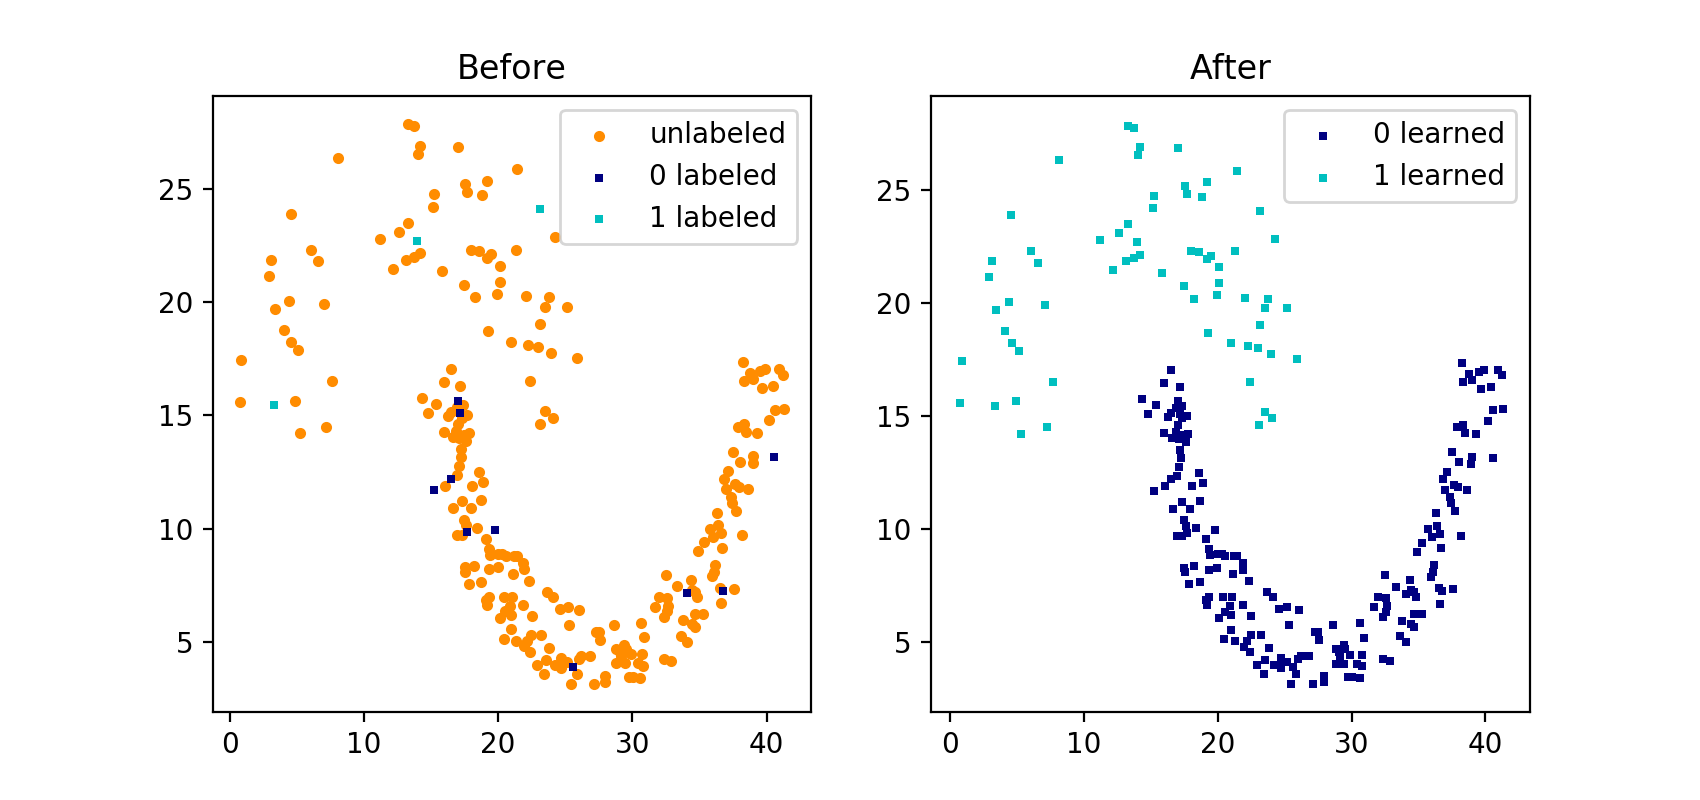

In [179]:
run('jain', 0.05)

<IPython.core.display.Javascript object>


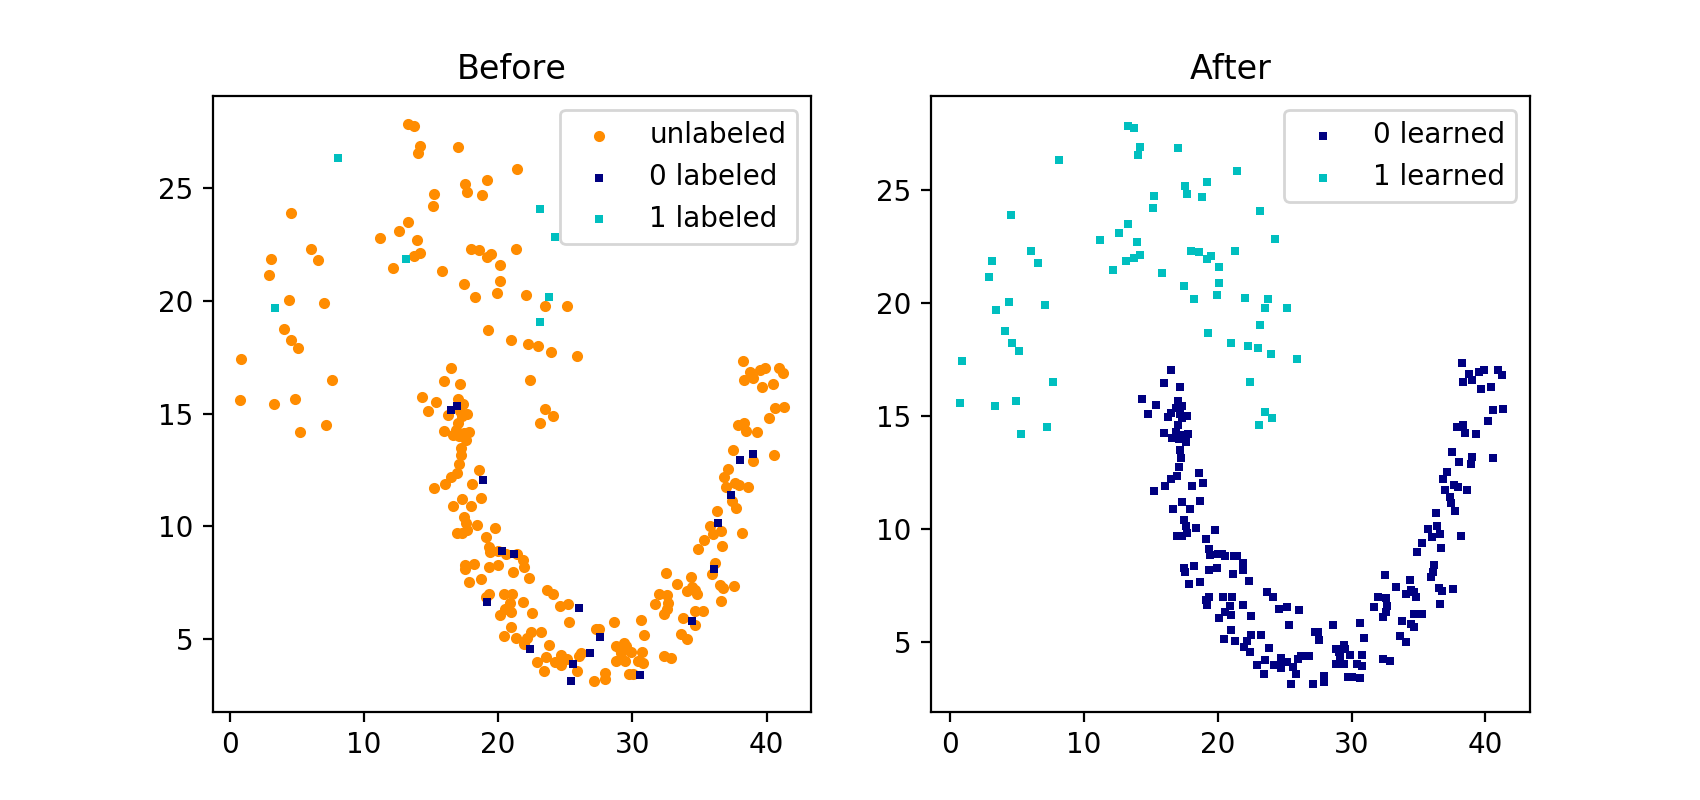

In [180]:
run('jain', 0.1)

<IPython.core.display.Javascript object>


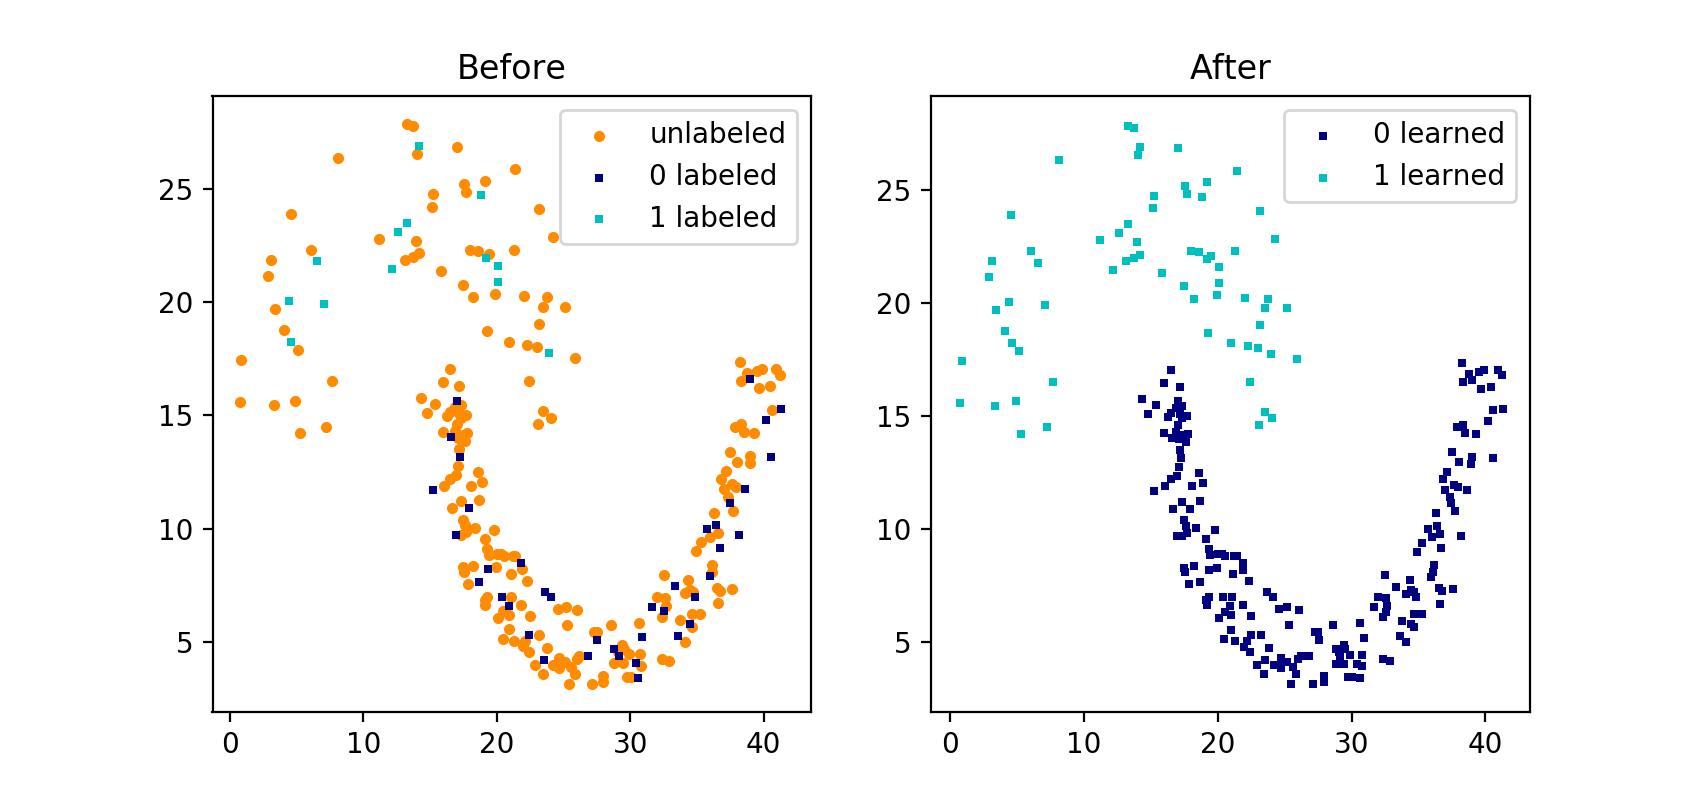

In [181]:
run('jain', 0.2)

<IPython.core.display.Javascript object>


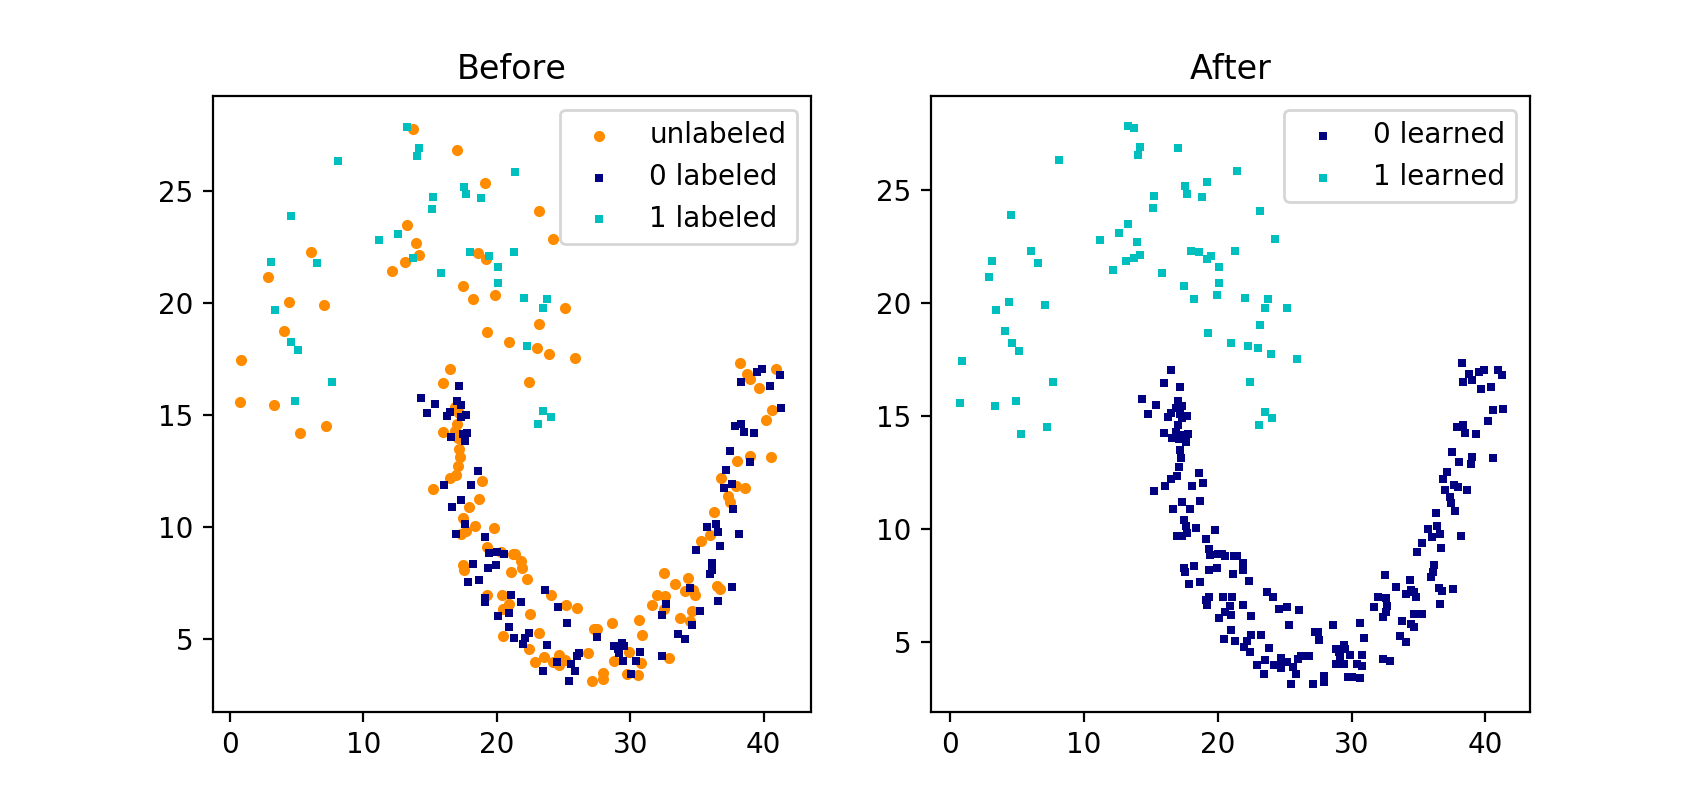

In [182]:
run('jain', 0.5)

## - tricircle

<IPython.core.display.Javascript object>


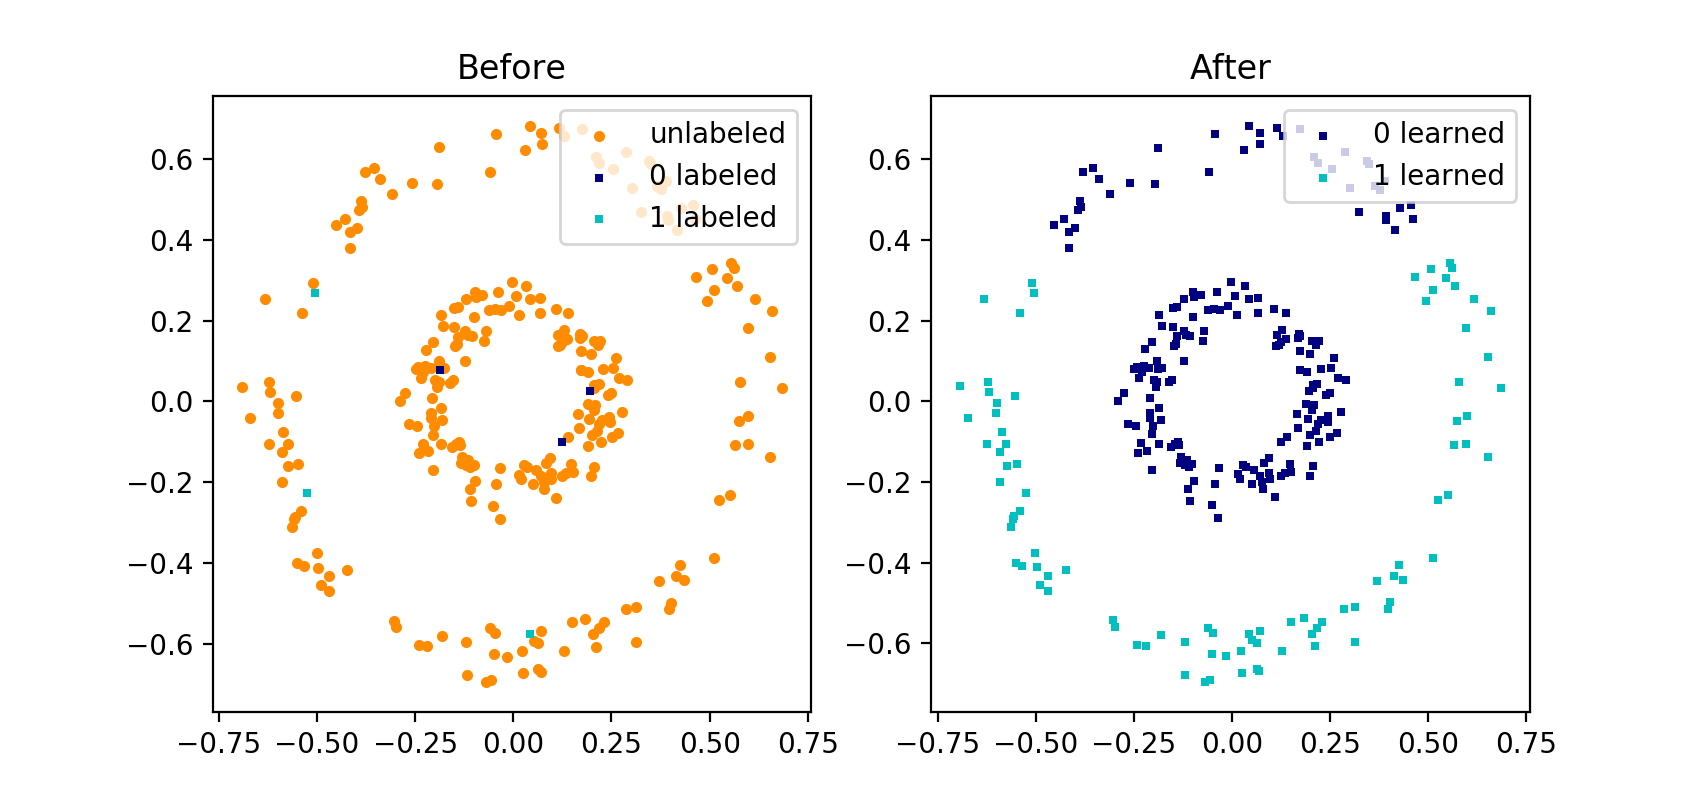

In [183]:
run('tricircle', 0.02)

<IPython.core.display.Javascript object>


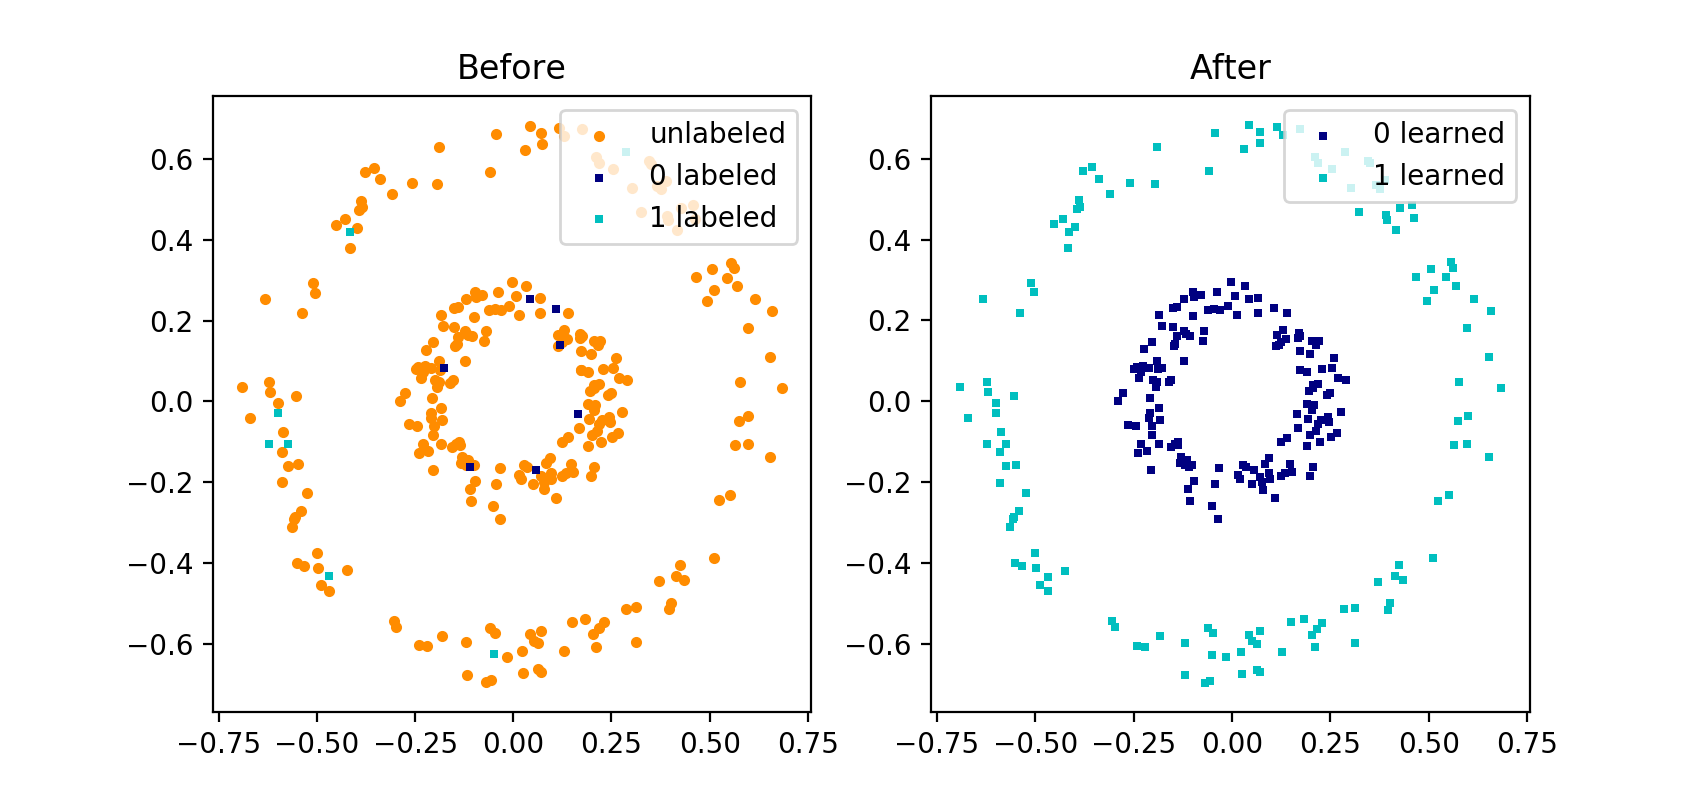

In [184]:
run('tricircle', 0.05)

<IPython.core.display.Javascript object>


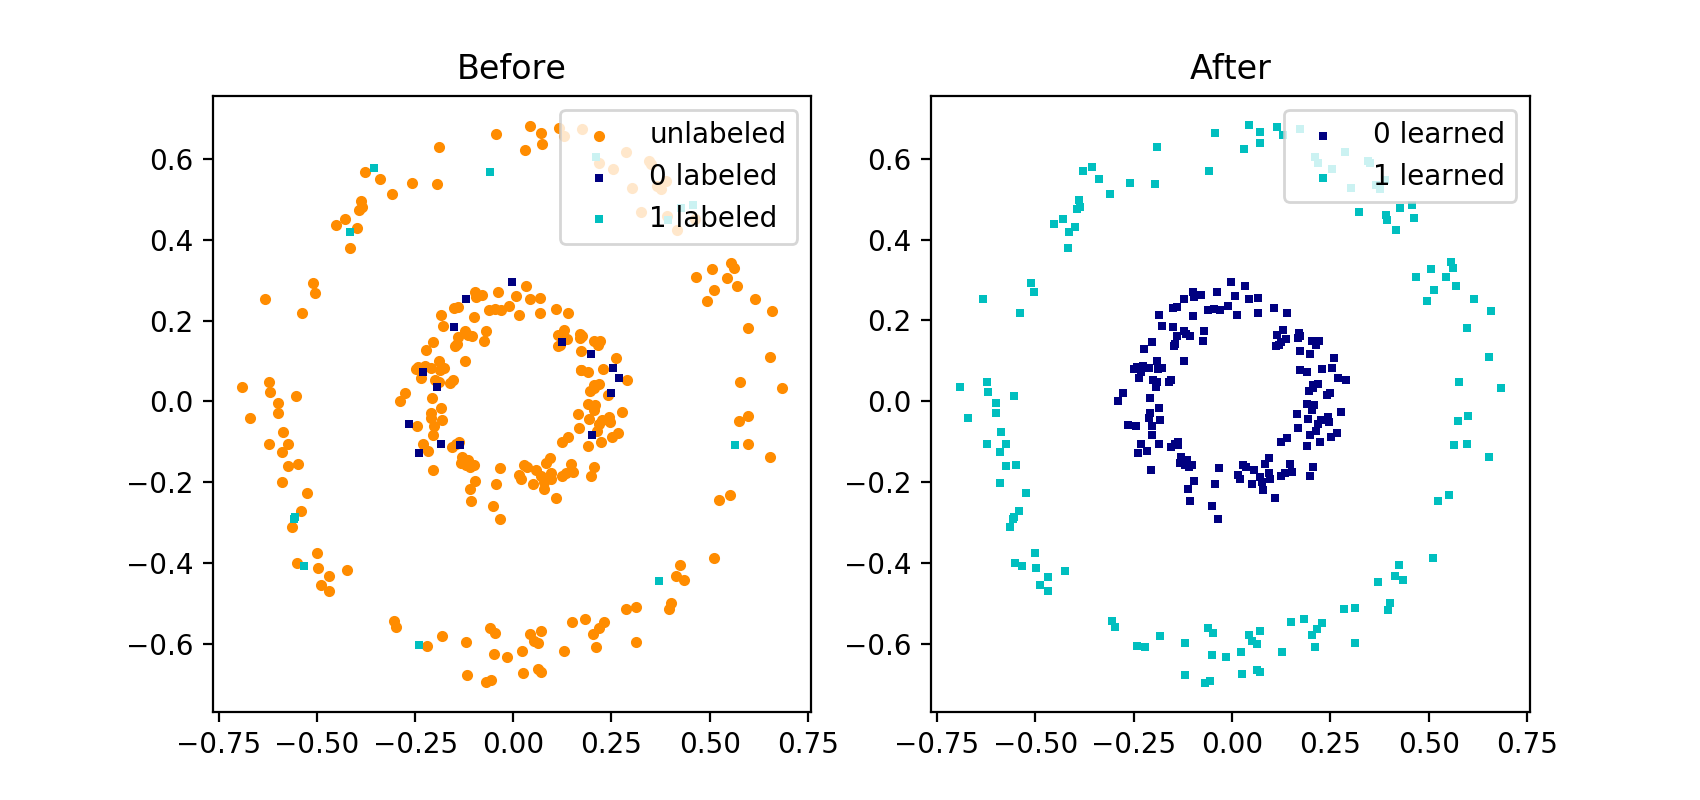

In [185]:
run('tricircle', 0.1)

<IPython.core.display.Javascript object>


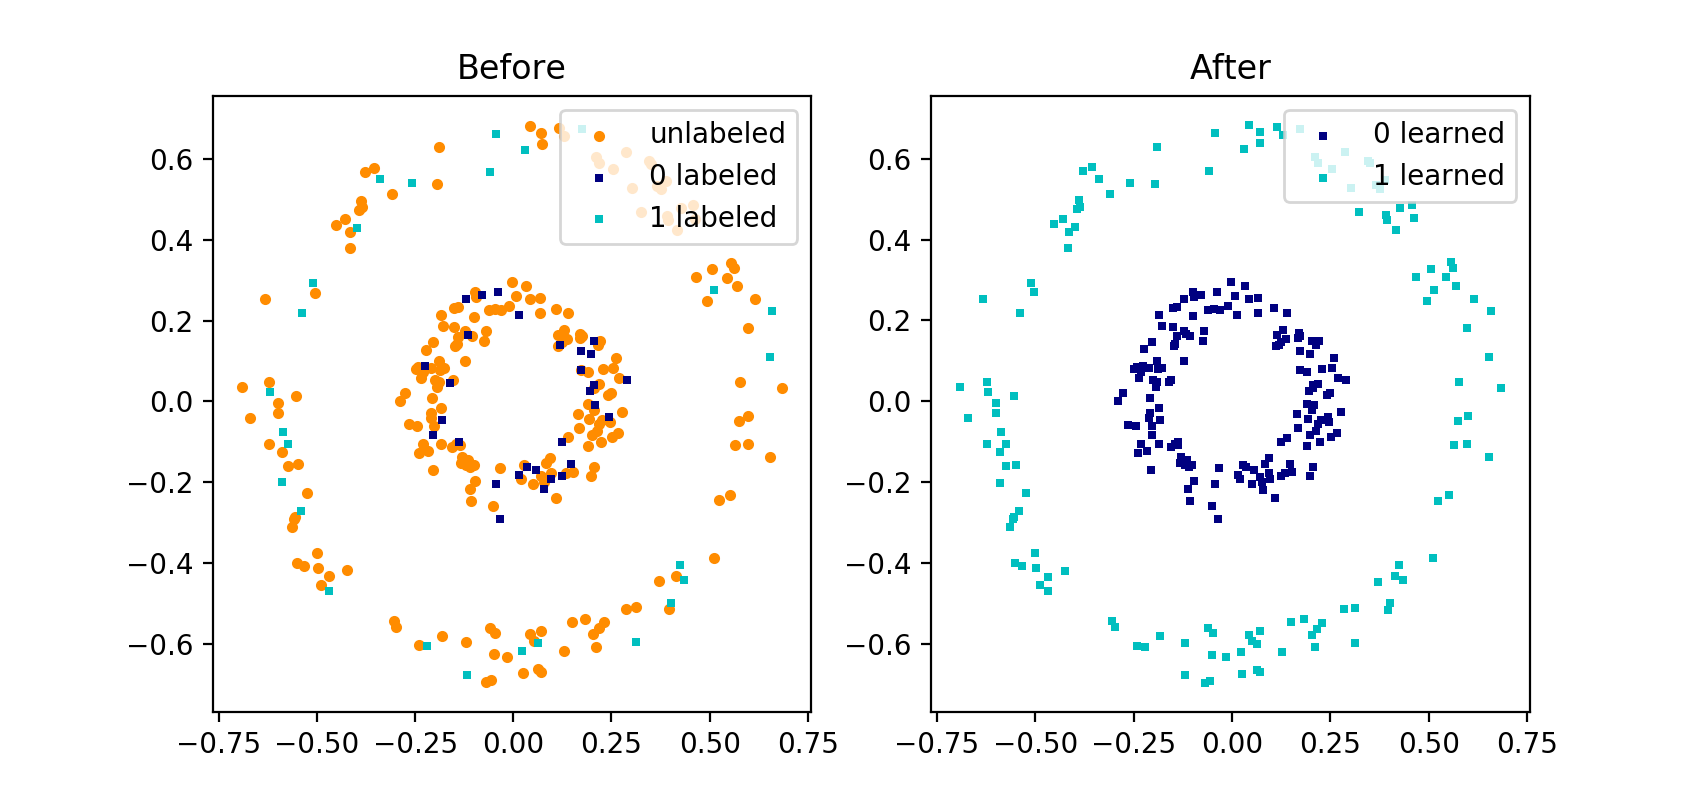

In [186]:
run('tricircle', 0.2)

<IPython.core.display.Javascript object>


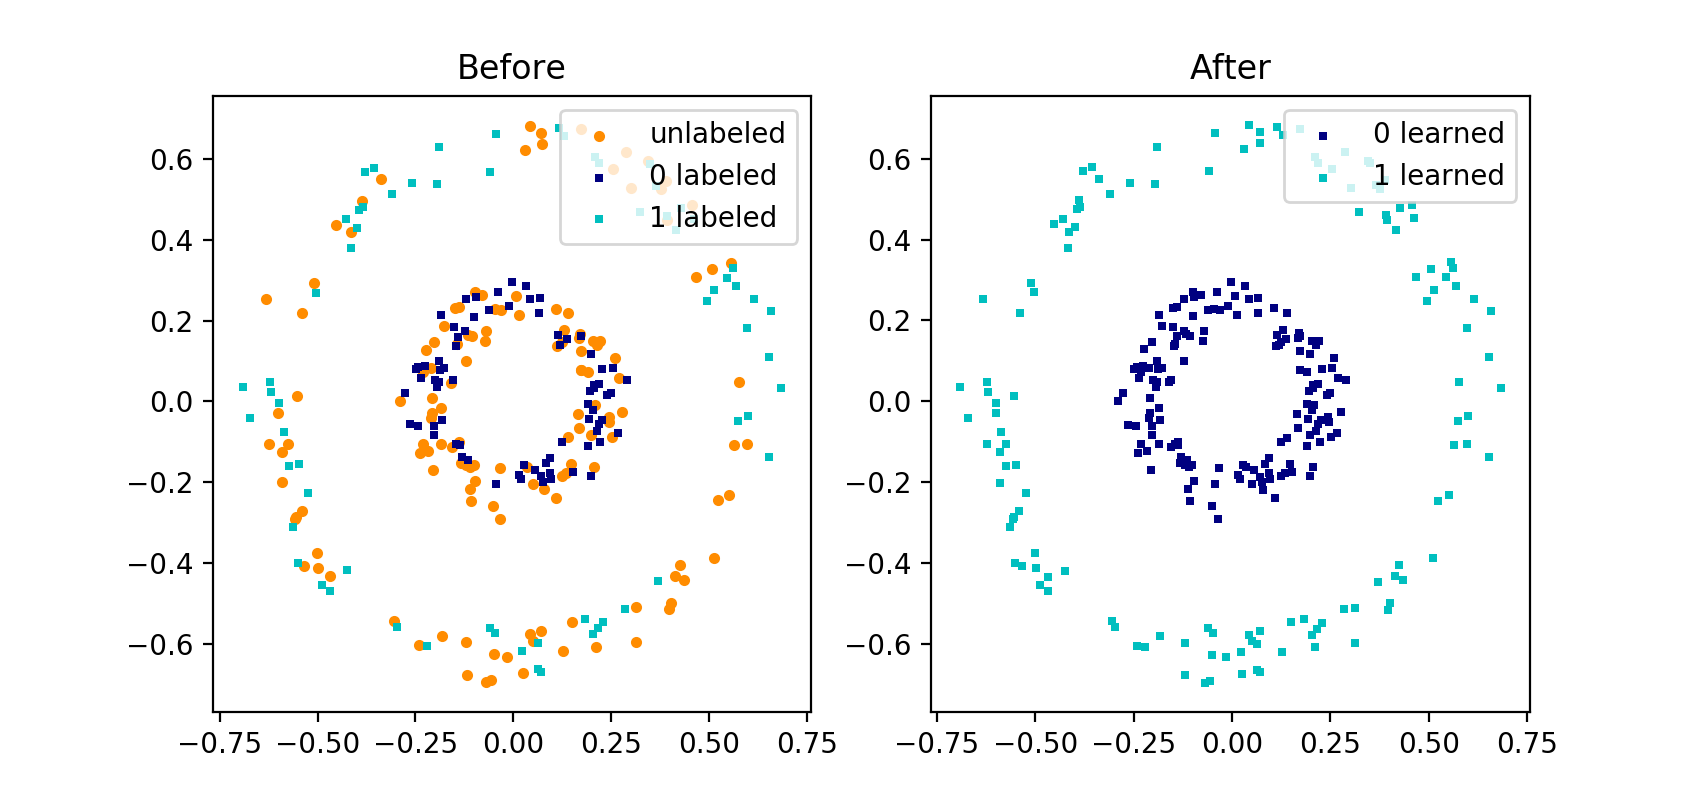

In [187]:
run('tricircle', 0.5)

## - trimoon

<IPython.core.display.Javascript object>


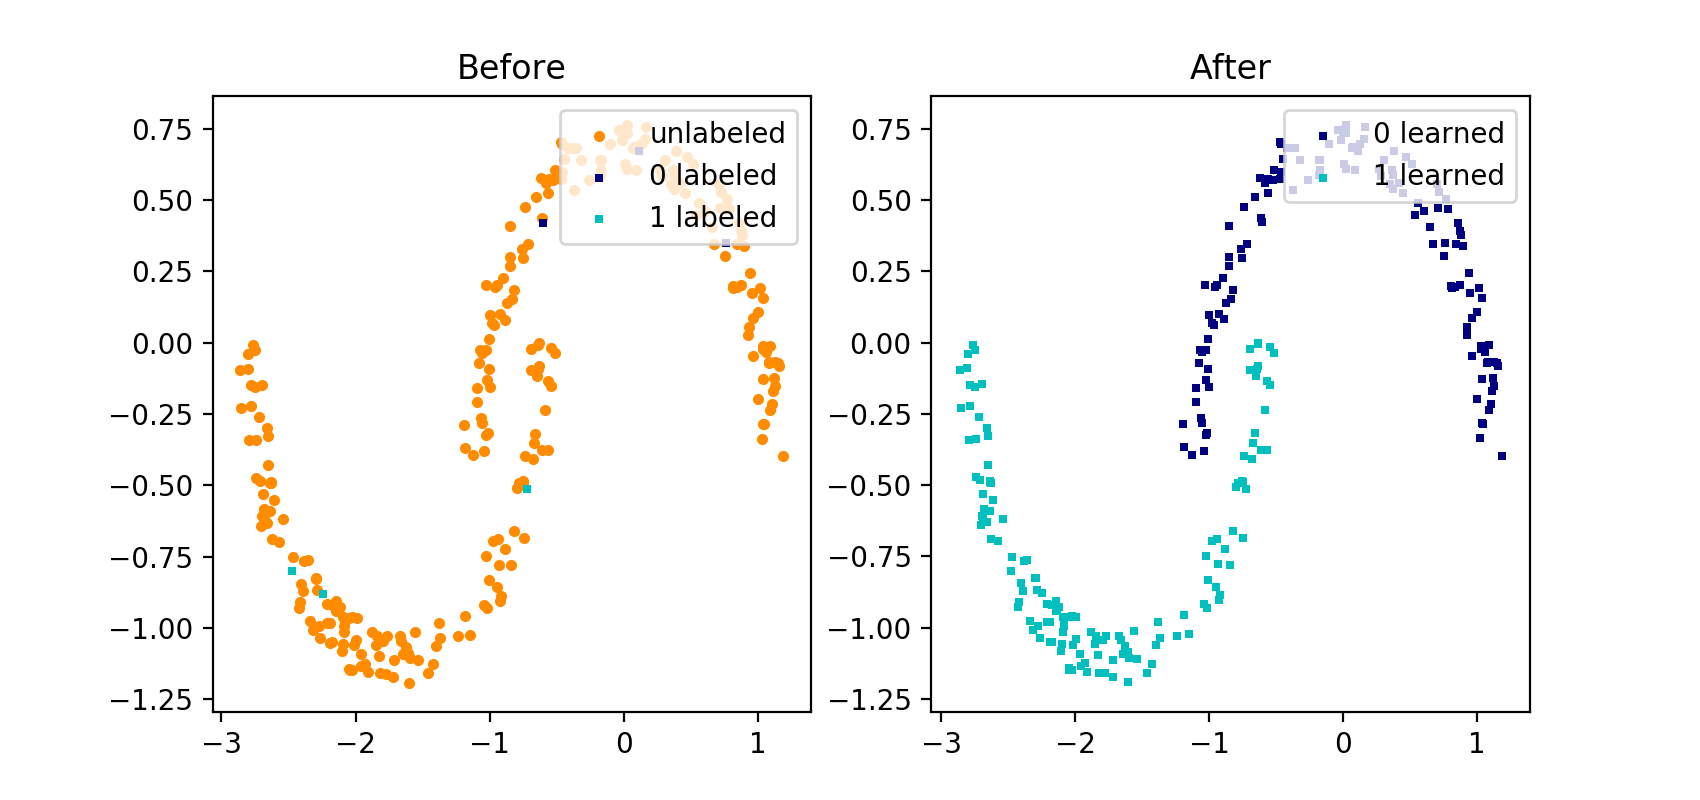

In [188]:
run('trimoon', 0.02)

<IPython.core.display.Javascript object>


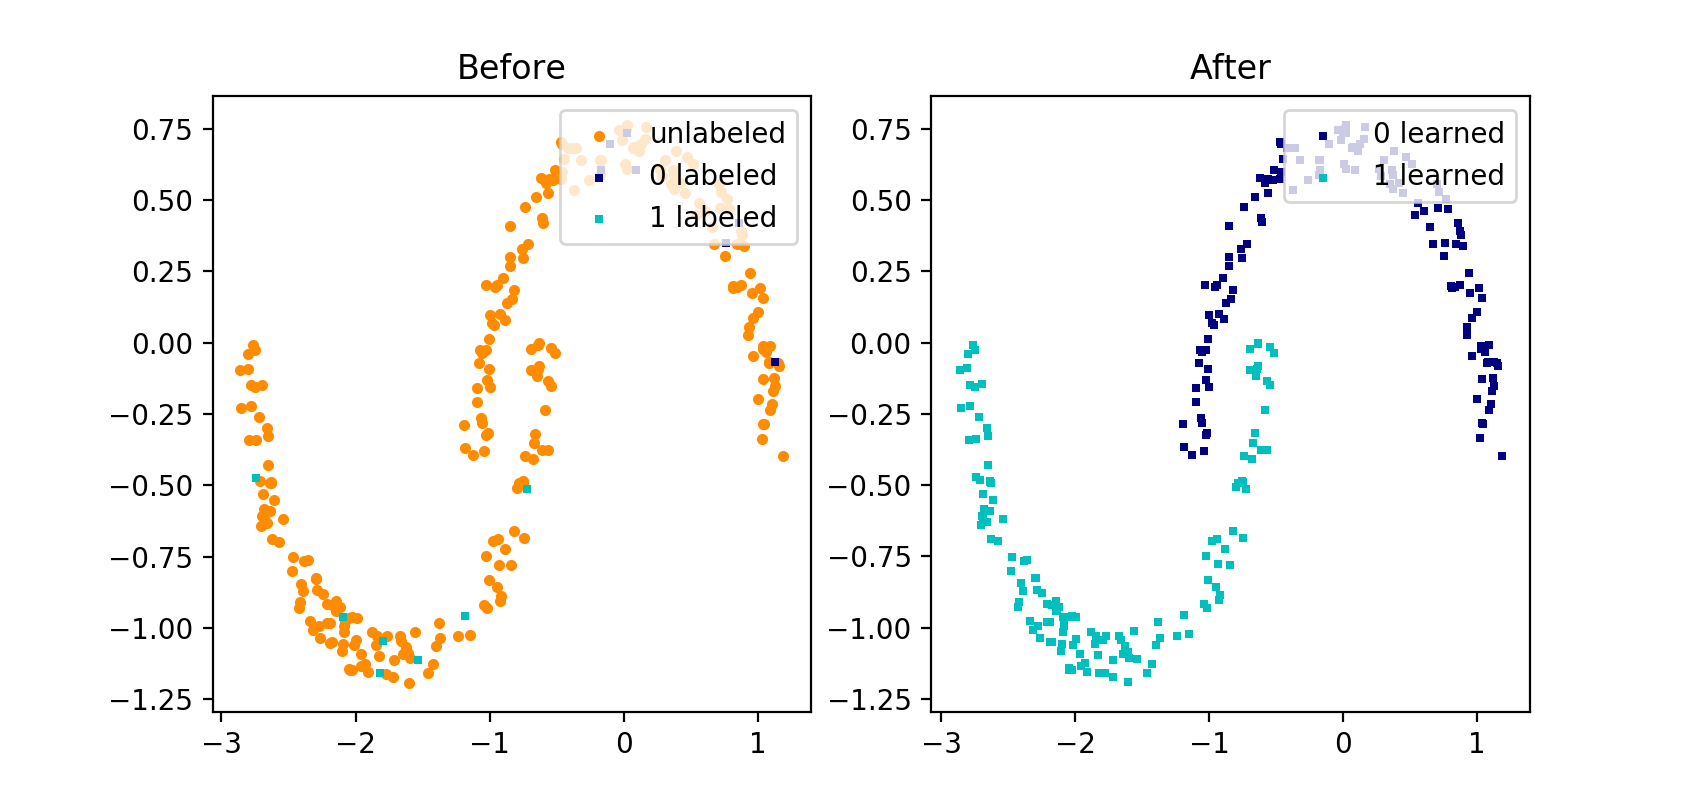

In [189]:
run('trimoon', 0.05)

<IPython.core.display.Javascript object>


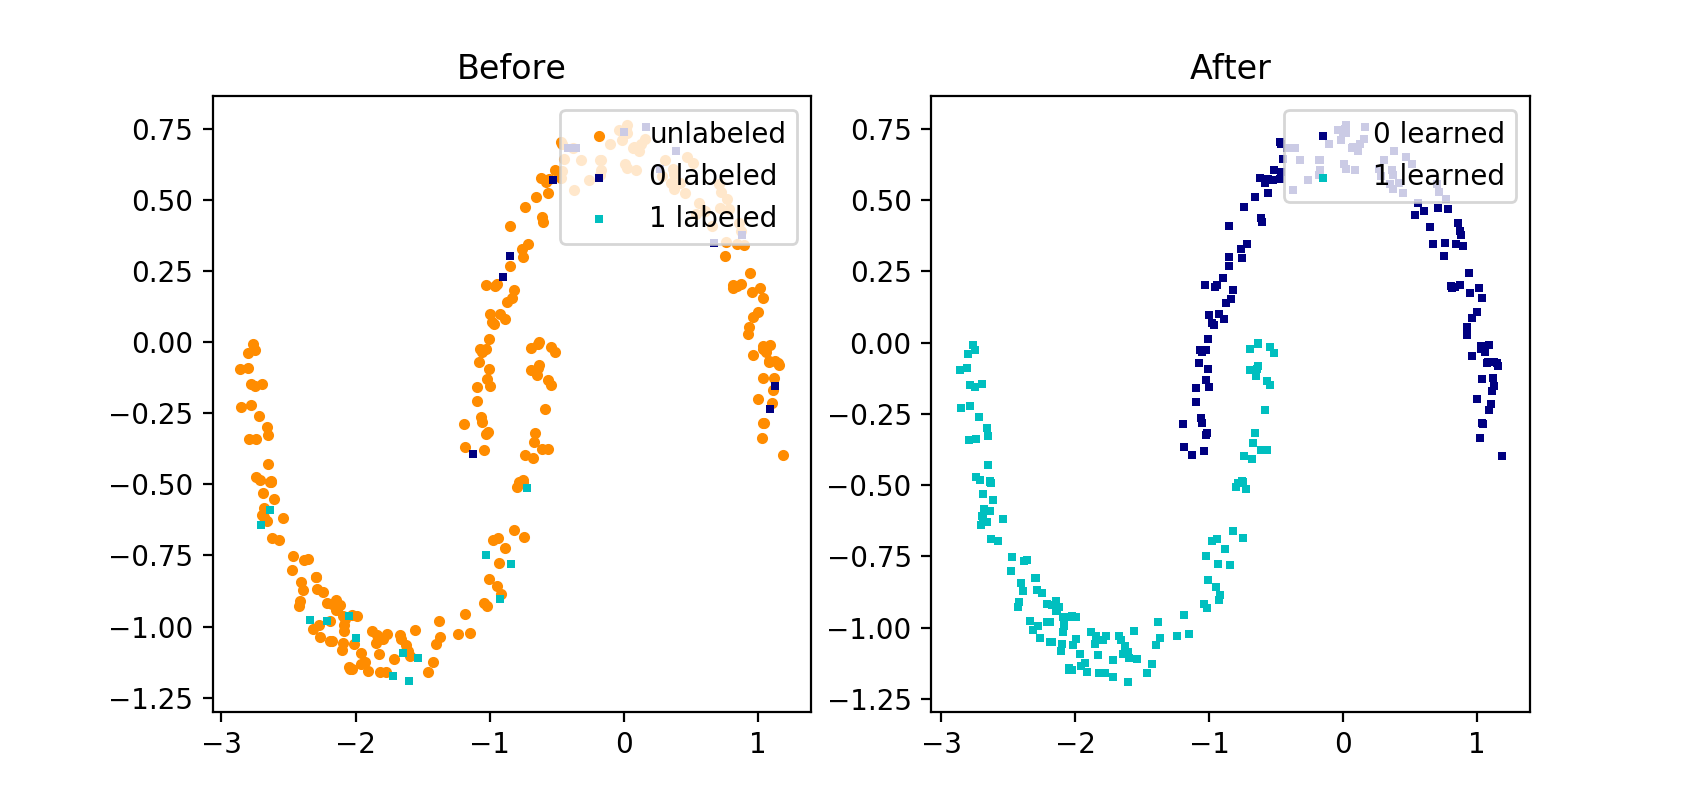

In [190]:
run('trimoon', 0.1)

<IPython.core.display.Javascript object>


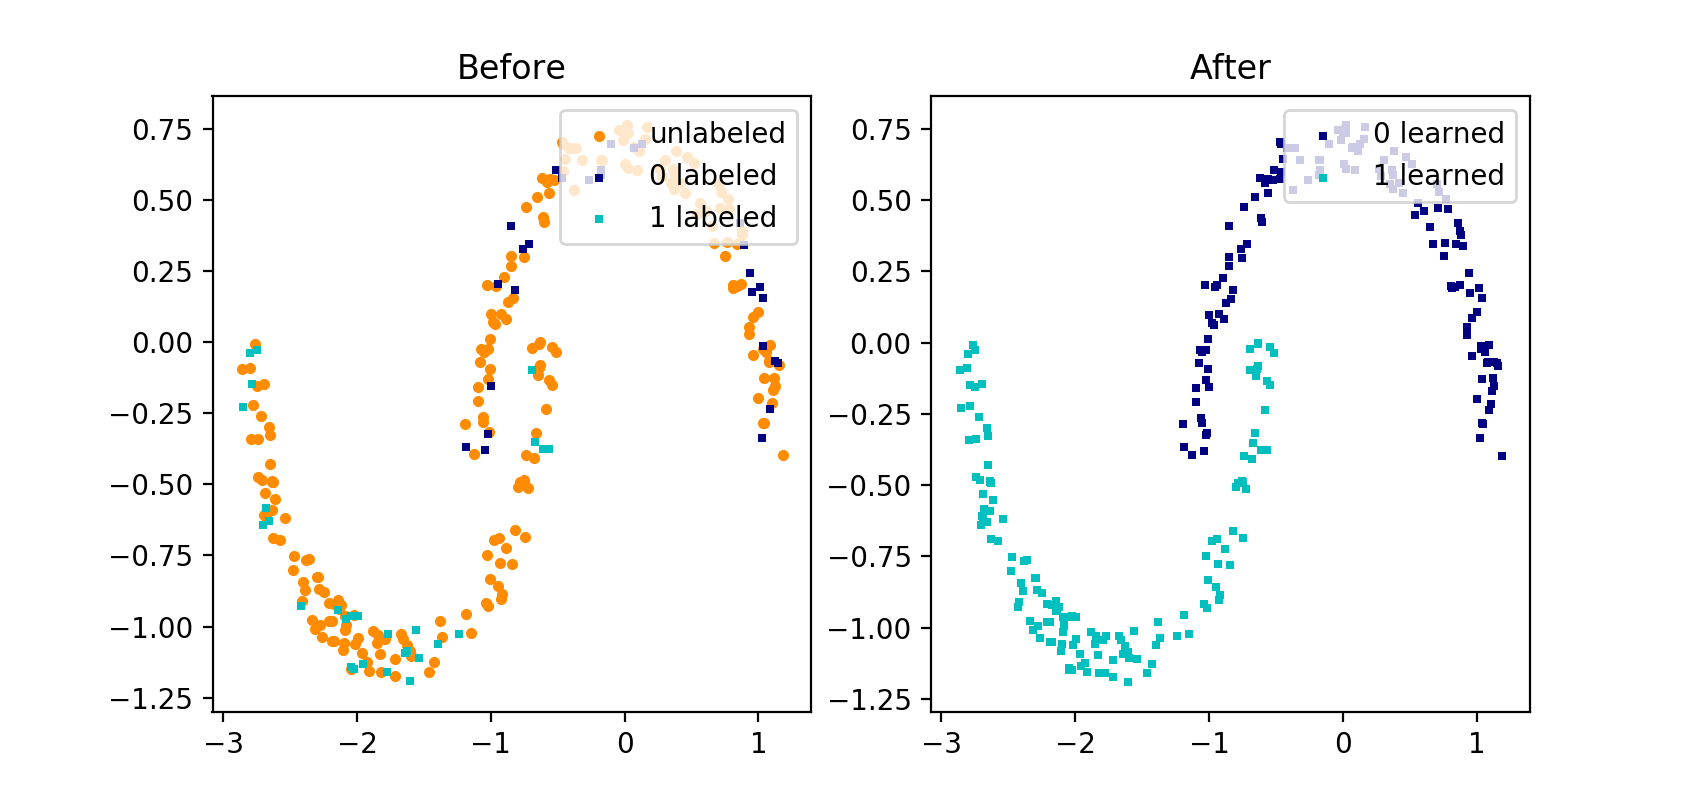

In [191]:
run('trimoon', 0.2)

<IPython.core.display.Javascript object>


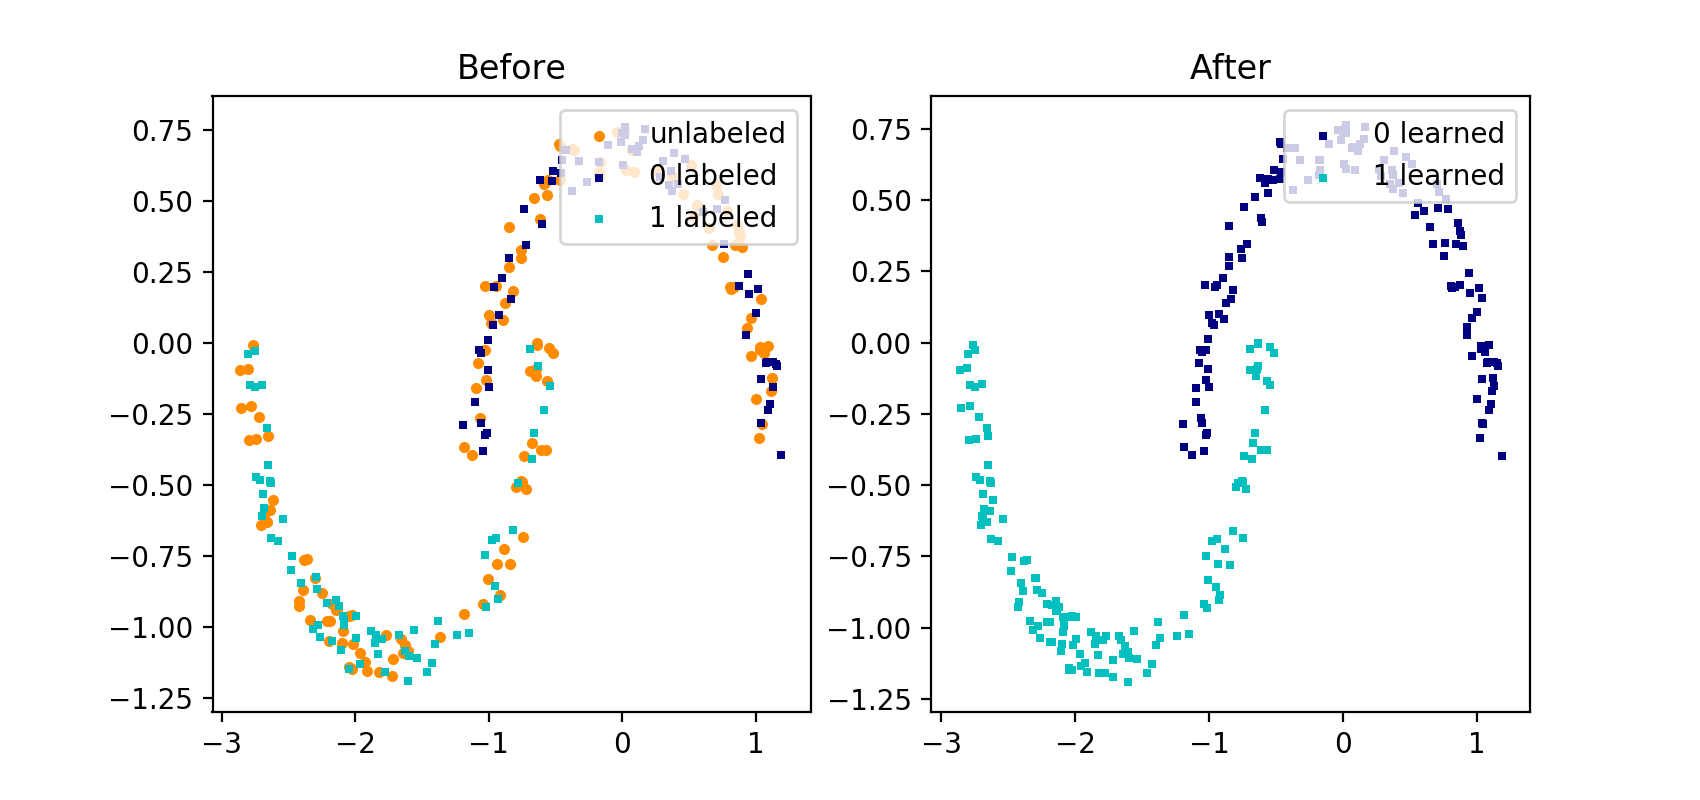

In [192]:
run('trimoon', 0.5)

## - twomoon

<IPython.core.display.Javascript object>


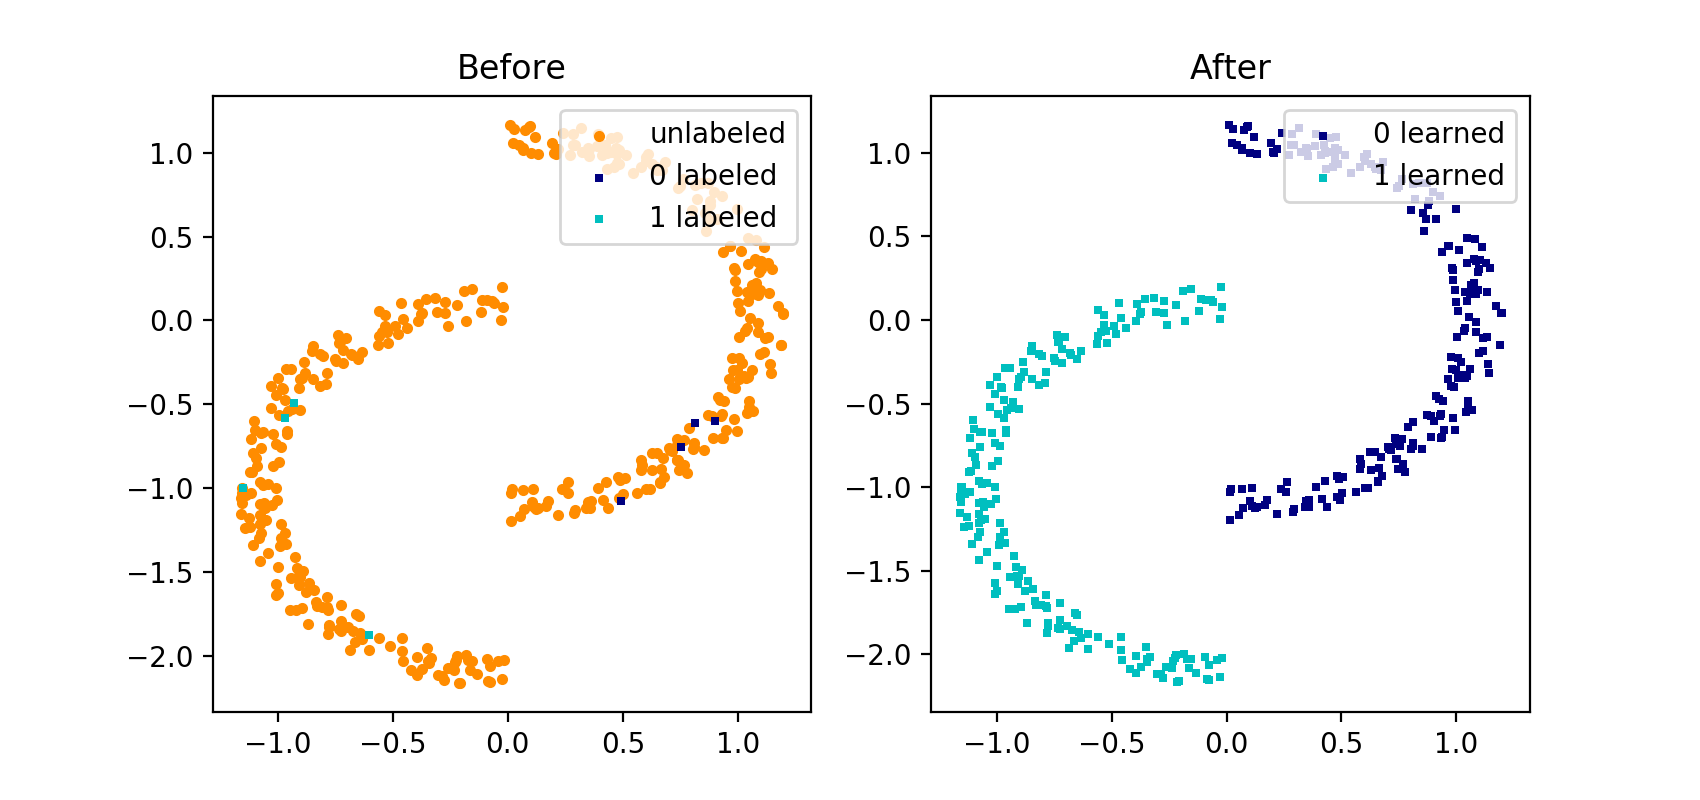

In [193]:
run('twomoon', 0.02)

<IPython.core.display.Javascript object>


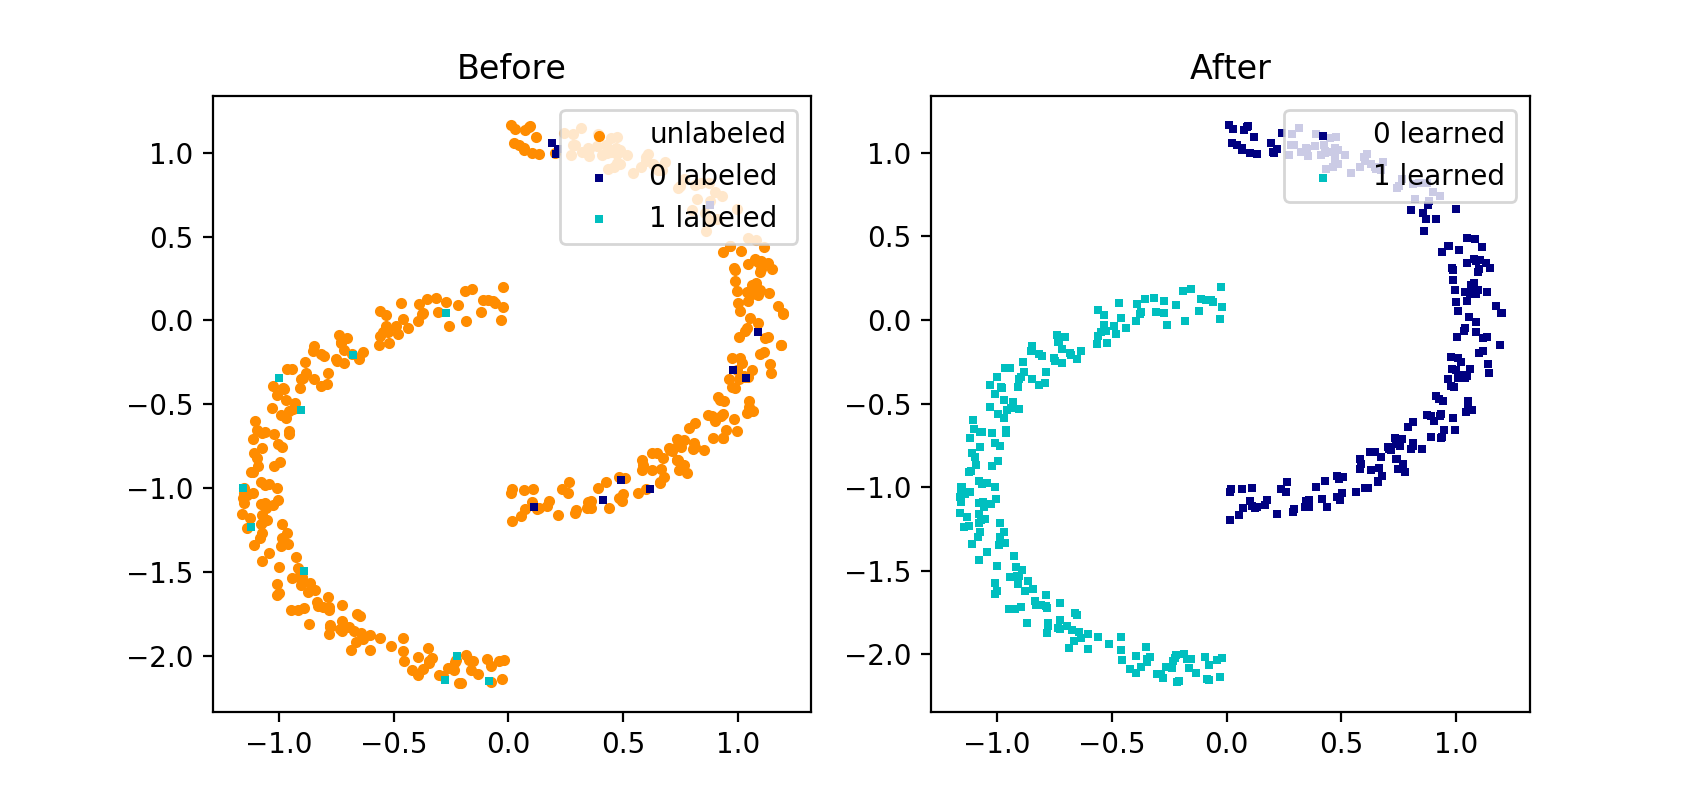

In [194]:
run('twomoon', 0.05)

<IPython.core.display.Javascript object>


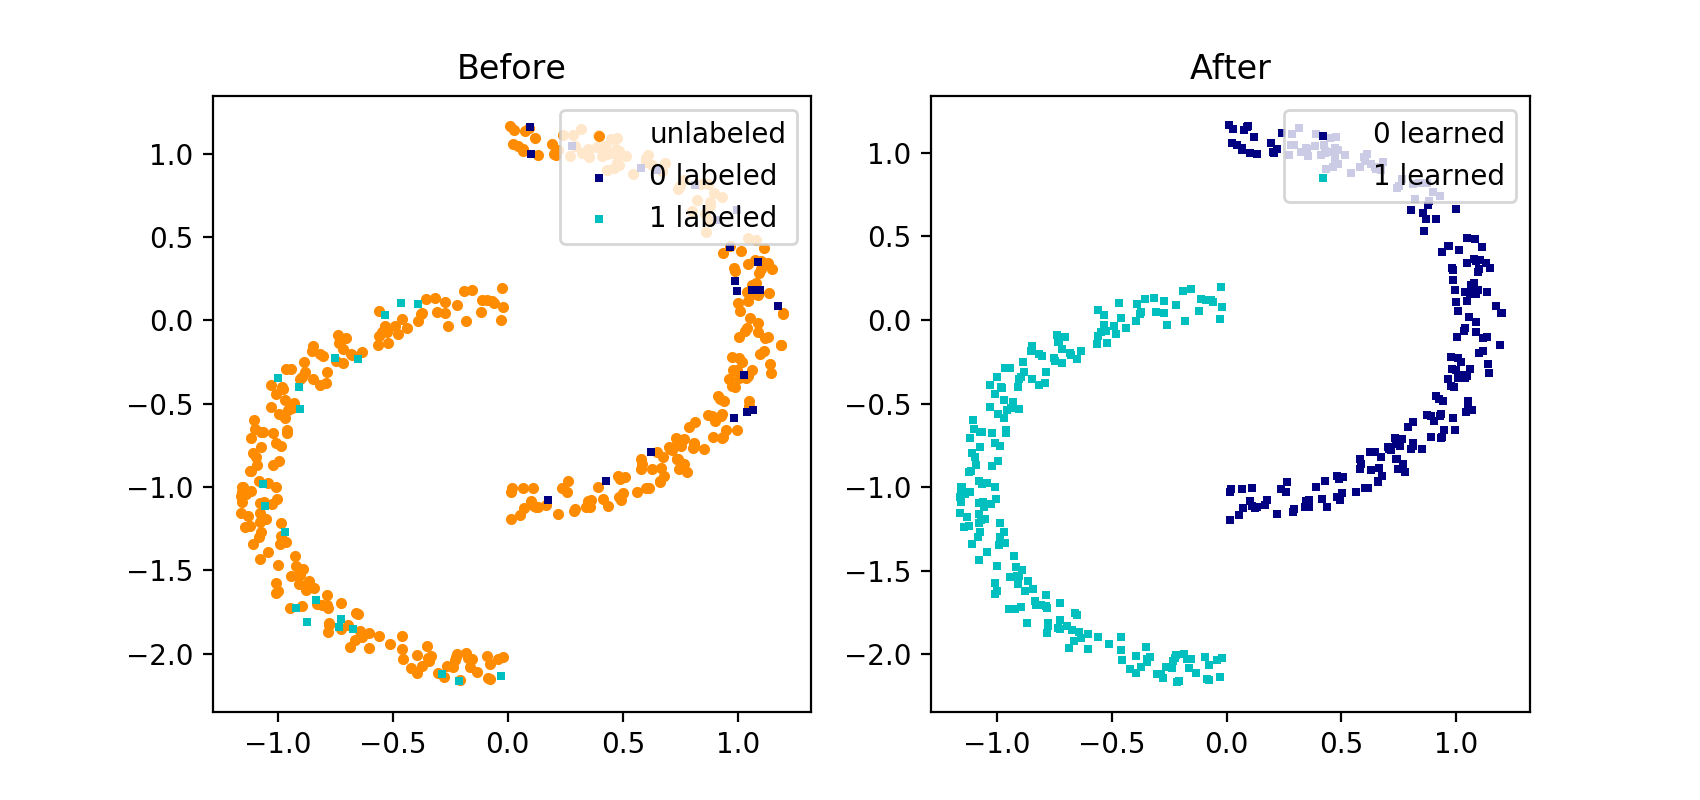

In [195]:
run('twomoon', 0.1)

<IPython.core.display.Javascript object>


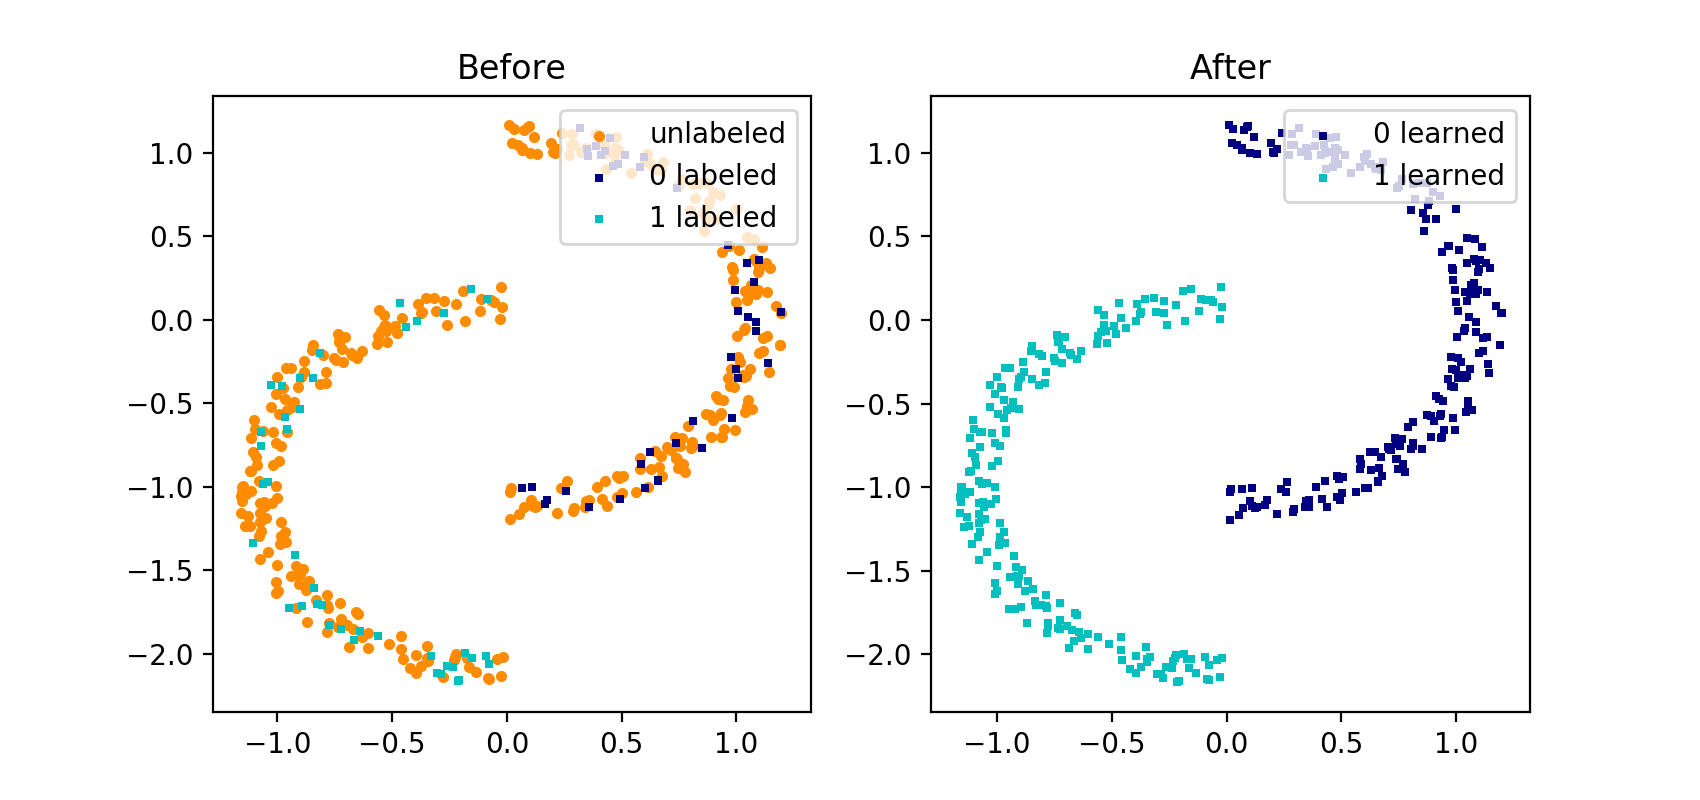

In [196]:
run('twomoon', 0.2)

<IPython.core.display.Javascript object>


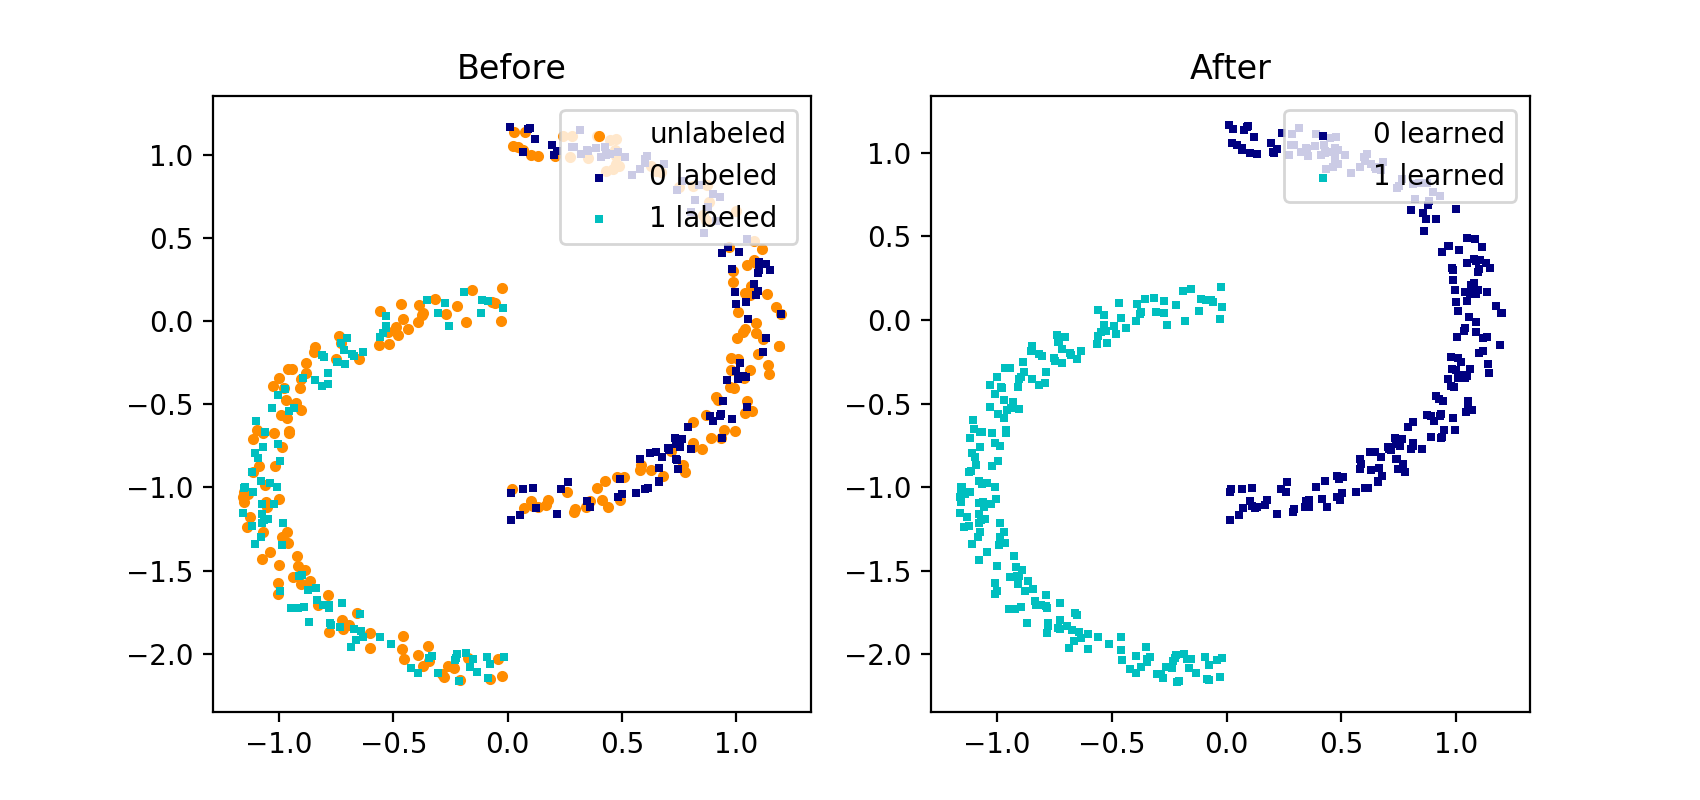

In [197]:
run('twomoon', 0.5)